# Проект: Анализ данных ДТП в России

**Описание:** исследовательский анализ данных о дорожно-транспортных происшествиях (ДТП), предоставленных на платформе «Карта ДТП» https://dtp-stat.ru/. Это некоммерческий проект, посвященный проблеме дорожно-транспортных происшествий в России, представляющий собой платформу сбора данных о ДТП, бесплатный и открытый сервис аналитики ДТП.

**Цель:** оценить безопасность движения на дорогах РФ и разработать рекомендации для снижения числа ДТП

**Данные:** данные в формате geojson с сайта https://dtp-stat.ru/opendata

Структура данных: 
- "id": идентификатор
- "tags": показатели с официального сайта ГИБДД
- "light": время суток
- "point": координаты
- "nearby": координаты
- "region": город/район
- "address": адрес
- "weather": погода
- "category": тип ДТП
- "datetime": дата и время
- "severity": тяжесть ДТП/вред здоровью
- "vehicles": участники – транспортные средства: 
  - "year": год производства транспортного средства
  - "brand": марка транспортного средства
  - "color": цвет транспортного средства
  - "model": модель транспортного средства
  - "category": категория транспортного средства
- "participants": участники внутри транспортных средств
  - "role": роль участника
  - "gender": пол участника
  - "violations": нарушения правил участником
  - "health_status":состояние здоровья участника
  - "years_of_driving_experience": стаж вождения участника (только у водителей)
- "dead_count": кол-во погибших в ДТП
- "participants": участники без транспортных средств (описание, как у участников внутри транспортных средств)
- "injured_count": кол-во раненых в ДТП
- "parent_region": регион
- "road_conditions": состояние дорожного покрытия
- "participants_count": кол-во участников ДТП
- "participant_categories": категории участников

## 1. Парсинг данных с сайта

In [1]:
#импорт библиотек
from bs4 import BeautifulSoup
import requests
import re
import geopandas as gpd
import pandas as pd
import json
import os 
import matplotlib.pyplot as plt
import datetime as dt
import dill as pickle
import glob
import seaborn as sns
import numpy as np
import math as mth
from scipy import stats as st

In [9]:
#загрузим страницу с данными
url='https://dtp-stat.ru/opendata'
response = requests.get(url)
print(response)

<Response [200]>


In [10]:
#получим исходный код страницы
bs = BeautifulSoup(response.text,"html.parser")
print(bs)


<!DOCTYPE html>

<html lang="ru">
<head>
<meta charset="utf-8"/>
<meta content="width=device-width, initial-scale=1" name="viewport"/>
<link href="/static/media/logo.ico" rel="shortcut icon" type="image/x-icon"/>
<!-- Yandex.Metrika counter -->
<script type="text/javascript">
       (function(m,e,t,r,i,k,a){m[i]=m[i]||function(){(m[i].a=m[i].a||[]).push(arguments)};
       m[i].l=1*new Date();k=e.createElement(t),a=e.getElementsByTagName(t)[0],k.async=1,k.src=r,a.parentNode.insertBefore(k,a)})
       (window, document, "script", "https://mc.yandex.ru/metrika/tag.js", "ym");

       ym(49130284, "init", {
            clickmap:true,
            trackLinks:true,
            accurateTrackBounce:true,
            webvisor:true
       });
    </script>
<noscript><div><img alt="" src="https://mc.yandex.ru/watch/49130284" style="position:absolute; left:-9999px;"/></div></noscript>
<!-- /Yandex.Metrika counter -->
<!-- Google tag (gtag.js) -->
<script async="" src="https://www.googletagmanager

In [11]:
#выберем нужные ссылки на данные
temp = bs.find_all('a', class_='button', limit=86)
print(temp)

[<a class="nav-link button support" href="/donate/">Поддержать проект</a>, <a class="button" href="https://cms.dtp-stat.ru/media/opendata/altaiskii-krai.geojson">Скачать .geojson</a>, <a class="button" href="https://cms.dtp-stat.ru/media/opendata/amurskaia-oblast.geojson">Скачать .geojson</a>, <a class="button" href="https://cms.dtp-stat.ru/media/opendata/arkhangelskaia-oblast.geojson">Скачать .geojson</a>, <a class="button" href="https://cms.dtp-stat.ru/media/opendata/astrakhanskaia-oblast.geojson">Скачать .geojson</a>, <a class="button" href="https://cms.dtp-stat.ru/media/opendata/belgorodskaia-oblast.geojson">Скачать .geojson</a>, <a class="button" href="https://cms.dtp-stat.ru/media/opendata/brianskaia-oblast.geojson">Скачать .geojson</a>, <a class="button" href="https://cms.dtp-stat.ru/media/opendata/vladimirskaia-oblast.geojson">Скачать .geojson</a>, <a class="button" href="https://cms.dtp-stat.ru/media/opendata/volgogradskaia-oblast.geojson">Скачать .geojson</a>, <a class="butto

In [12]:
#создадим список с ссылками
urls=[]
for element in temp:
    url=element.get('href')
    urls.append(url)

In [13]:
urls = urls[1:]
urls

['https://cms.dtp-stat.ru/media/opendata/altaiskii-krai.geojson',
 'https://cms.dtp-stat.ru/media/opendata/amurskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/arkhangelskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/astrakhanskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/belgorodskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/brianskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/vladimirskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/volgogradskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/vologodskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/voronezhskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/evreiskaia-avtonomnaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/zabaikalskii-krai.geojson',
 'https://cms.dtp-stat.ru/media/opendata/ivanovskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/irkutskaia-oblast.geojson',
 '

In [14]:
#загрузим данные
for u in urls:
    filename = u.split('/')[-1]
    resp = requests.get(u)
    open(filename, "wb").write(resp.content)

**Вывод:** В результате парсинга мы получили 85 файлов, с данными по каждому региону РФ. 

## 2. Изучение данных

In [20]:
#ознакомимся с данными по первому региону
df=pd.read_json('C:/Users/Yulia/Desktop/Yandex Practicum/Мастерская/ДТП/altaiskii-krai.geojson')
df.head()

,type,features
0,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Poin..."
1,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Poin..."
2,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Poin..."
3,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Poin..."
4,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Poin..."


In [21]:
#нормализуем данные
df=pd.json_normalize(df['features'])
pd.set_option('display.max_columns', None)
df.head()

,type,geometry.type,geometry.coordinates,properties.id,properties.tags,properties.light,properties.point.lat,properties.point.long,properties.nearby,properties.region,properties.scheme,properties.address,properties.weather,properties.category,properties.datetime,properties.severity,properties.vehicles,properties.dead_count,properties.participants,properties.injured_count,properties.parent_region,properties.road_conditions,properties.participants_count,properties.participant_categories
0,Feature,Point,"[83.7879, 53.3912]",2869171,[Дорожно-транспортные происшествия],Светлое время суток,53.391200,83.787900,[Жилые дома индивидуальной застройки],Барнаул,830,None,[Ясно],Наезд на пешехода,2023-05-24 19:30:00,Легкий,"[{'year': 2015, 'brand': 'Прочие марки ТС', 'c...",0,"[{'role': 'Пешеход', 'gender': 'Мужской', 'vio...",1,Алтайский край,[Сухое],2,"[Все участники, Пешеходы, Мотоциклисты]"
1,Feature,Point,"[83.666389, 53.345833]",2320091,"[Дорожно-транспортные происшествия, ДТП и пост...",Светлое время суток,53.345833,83.666389,"[Многоквартирные жилые дома, Внутридворовая те...",Барнаул,880,"г Барнаул, ул Сиреневая, 11",[Пасмурно],Иной вид ДТП,2015-09-16 13:00:00,Легкий,"[{'year': 2002, 'brand': 'TOYOTA', 'color': 'С...",0,[],1,Алтайский край,[Сухое],2,"[Дети, Все участники]"
2,Feature,Point,"[83.39688, 53.19706]",2321011,"[Дорожно-транспортные происшествия, ДТП и пост...",Светлое время суток,53.197060,83.396880,"[Административные здания, Остановка общественн...",Барнаул,960,"г Барнаул, ул Попова, 165",[Ясно],Падение пассажира,2017-08-25 15:30:00,Легкий,"[{'year': 1981, 'brand': 'DAIMLER', 'color': '...",0,[],1,Алтайский край,[Сухое],3,"[Дети, Все участники]"
3,Feature,Point,"[83.7142, 53.3764]",2576909,[Дорожно-транспортные происшествия],Светлое время суток,53.376400,83.714200,"[Выезд с прилегающей территории, Административ...",Барнаул,130,"г Барнаул, ул Петра Сухова, 83 А",[Ясно],Столкновение,2021-05-29 19:40:00,Тяжёлый,"[{'year': 2001, 'brand': 'HONDA', 'color': 'Се...",0,[],1,Алтайский край,"[Сухое, Отсутствие, плохая различимость горизо...",3,"[Мотоциклисты, Все участники]"
4,Feature,Point,"[83.794366, 53.343071]",2575209,[Дорожно-транспортные происшествия],Светлое время суток,53.343071,83.794366,"[Многоквартирные жилые дома, Жилые дома индиви...",Барнаул,500,"г Барнаул, ул Партизанская, 26",[Ясно],Столкновение,2021-05-25 16:40:00,Легкий,"[{'year': 2014, 'brand': 'NISSAN', 'color': 'С...",0,[],1,Алтайский край,"[Сухое, Отсутствие, плохая различимость горизо...",2,[Все участники]


In [22]:
df.columns = [col.split('.')[-1] for col in df.columns]
df = df.drop(['type'], axis = 1)

In [23]:
#раскроем столбец vehicles
vehicles = pd.json_normalize(df.explode('vehicles')['vehicles'])
vehicles.head()

,year,brand,color,model,category,participants
0,2015.0,Прочие марки ТС,Черный,Прочие марки и модели ТС,Мопеды с двигателем внутреннего сгорания менее...,"[{'role': 'Водитель', 'gender': 'Мужской', 'vi..."
1,2002.0,TOYOTA,Серый,Corolla,"С-класс (малый средний, компактный) до 4,3 м","[{'role': 'Водитель', 'gender': 'Мужской', 'vi..."
2,1981.0,DAIMLER,Многоцветный,Прочие модели DAIMLER,Одноэтажные длиной от 8 до 12 м,"[{'role': 'Водитель', 'gender': 'Мужской', 'vi..."
3,2001.0,HONDA,Серый,Torneo,"В-класс (малый) до 3,9 м","[{'role': 'Водитель', 'gender': 'Женский', 'vi..."
4,1987.0,HONDA,Синий,Magna,Мотоциклы,"[{'role': 'Пассажир', 'gender': 'Женский', 'vi..."


In [25]:
vehicles[vehicles['category'] == "Одноэтажные длиной от 5 до 8 м"]['model'].unique()

array(['Прочие модели ГАЗ', '3204', 'County', '5256',
       'Прочие модели DAIMLER', 'Прочие модели King Long', 'Next',
       'O 405', 'Прочие марки и модели ТС', '32054', 'Прочие модели ПАЗ',
       None, 'Прочие модели Mercedes', 'Transit', 'Прочие модели Scania',
       '2250 (автобусы) и модификации', 'Прочие марки автобусов', 'Boxer',
       '113', 'Vector NEXT', 'Ducato', 'Прочие модели автобусов БОГДАН',
       'OMNI', '4234', '2250 (грузовые) и модификации', 'HD',
       'Прочие модели Hyundai', 'Прочие модели Higer', '32053',
       'Прочие модели CITROEN', 'Sprinter',
       '3221  Газель , 32217, 32213, 32212, 322172, 322132, 322133 и модификации',
       'Прочие модели ЛИАЗ', '3203', 'А092.02', 'Прочие модели Ford',
       'Прочие модели КАВЗ', '5293', 'Прочие модели FIAT', 'Aero Space',
       'Прочие модели ISUZU', 'Прочие модели PEUGEOT',
       '5256 (пригородный)', 'Grandbird Blue Sky',
       'Прочие модели Citroen', 'Прочие модели SSANGYONG', 'Jumper',
       'Проч

In [38]:
#добавим столбец id
vehicles = pd.concat([pd.DataFrame(df.explode('vehicles')['id'].values, columns=['id']), vehicles], axis=1)
vehicles.head()

,id,year,brand,color,model,category,participants
0,2869171,2015.0,Прочие марки ТС,Черный,Прочие марки и модели ТС,Мопеды с двигателем внутреннего сгорания менее...,"[{'role': 'Водитель', 'gender': 'Мужской', 'vi..."
1,2320091,2002.0,TOYOTA,Серый,Corolla,"С-класс (малый средний, компактный) до 4,3 м","[{'role': 'Водитель', 'gender': 'Мужской', 'vi..."
2,2321011,1981.0,DAIMLER,Многоцветный,Прочие модели DAIMLER,Одноэтажные длиной от 8 до 12 м,"[{'role': 'Водитель', 'gender': 'Мужской', 'vi..."
3,2576909,2001.0,HONDA,Серый,Torneo,"В-класс (малый) до 3,9 м","[{'role': 'Водитель', 'gender': 'Женский', 'vi..."
4,2576909,1987.0,HONDA,Синий,Magna,Мотоциклы,"[{'role': 'Пассажир', 'gender': 'Женский', 'vi..."


In [39]:
#раскроем столбец participants с инфомацей о участниках ДТП внутри ТС
vehicles_participants = pd.json_normalize(vehicles.explode('participants')['participants'])
vehicles_participants.head()

,role,gender,violations,health_status,years_of_driving_experience
0,Водитель,Мужской,"[Управление мопедом лицом моложе 16 лет, Управ...",Не пострадал,NaN
1,Водитель,Мужской,"[Несоблюдение условий, разрешающих движение тр...",Не пострадал,14.0
2,Водитель,Мужской,[],Не пострадал,25.0
3,Пассажир,Женский,[Нарушение правил пользования общественным тра...,Не пострадал,NaN
4,Пассажир,Женский,[],"Раненый, находящийся (находившийся) на амбула...",NaN


In [40]:
#добавим столбец id
vehicles_participants = pd.concat([pd.DataFrame(vehicles.explode('participants')['id'].values, columns=['id']), vehicles_participants], axis=1)
vehicles_participants.head()

,id,role,gender,violations,health_status,years_of_driving_experience
0,2869171,Водитель,Мужской,"[Управление мопедом лицом моложе 16 лет, Управ...",Не пострадал,NaN
1,2320091,Водитель,Мужской,"[Несоблюдение условий, разрешающих движение тр...",Не пострадал,14.0
2,2321011,Водитель,Мужской,[],Не пострадал,25.0
3,2321011,Пассажир,Женский,[Нарушение правил пользования общественным тра...,Не пострадал,NaN
4,2321011,Пассажир,Женский,[],"Раненый, находящийся (находившийся) на амбула...",NaN


In [5]:
#раскроем столбец participants с инфомацей о участниках ДТП без ТС
participants = pd.json_normalize(df.explode('participants')['participants'])
participants.head()

,role,gender,violations,health_status
0,Пешеход,Мужской,[],"Раненый, находящийся (находившийся) на амбулат..."
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN


In [6]:
#добавим столбец id
participants = pd.concat([pd.DataFrame(df.explode('participants')['id'].values, columns=['id']), participants], axis=1)
participants.head()

,id,role,gender,violations,health_status
0,2869171,Пешеход,Мужской,[],"Раненый, находящийся (находившийся) на амбулат..."
1,2320091,NaN,NaN,NaN,NaN
2,2321011,NaN,NaN,NaN,NaN
3,2576909,NaN,NaN,NaN,NaN
4,2575209,NaN,NaN,NaN,NaN


In [13]:
#удалим столбцы дубли
df = df.drop(['vehicles','participants'], axis=1)
vehicles = vehicles.drop(['participants'], axis=1)

In [7]:
#создадим функцию для исследования данных 

def first_look_data(data):
    display(data.head())
    print('Колонки')
    print(data.columns)
    print(50*'-')
    print('Содержимое колонок')
    print(20*'*')
    for col in data:
        print(col)
        try:
            print(data[col].unique())
            print(data[col].nunique())
        except TypeError:
            print('Списковое исключение')
            print(data[col][:5])

        print(20*'*')
    print('Общая информация')
    print(data.info())
    print(50*"-")
    print('Пропуски')
    print(data.isna().sum())
    print(50*"-")

In [74]:
#изучим основной датасет
first_look_data(df)

,coordinates,id,tags,light,lat,long,nearby,region,scheme,address,weather,category,datetime,severity,dead_count,injured_count,parent_region,road_conditions,participants_count,participant_categories
0,"[83.7879, 53.3912]",2869171,[Дорожно-транспортные происшествия],Светлое время суток,53.391200,83.787900,[Жилые дома индивидуальной застройки],Барнаул,830,None,[Ясно],Наезд на пешехода,2023-05-24 19:30:00,Легкий,0,1,Алтайский край,[Сухое],2,"[Все участники, Пешеходы, Мотоциклисты]"
1,"[83.666389, 53.345833]",2320091,"[Дорожно-транспортные происшествия, ДТП и пост...",Светлое время суток,53.345833,83.666389,"[Многоквартирные жилые дома, Внутридворовая те...",Барнаул,880,"г Барнаул, ул Сиреневая, 11",[Пасмурно],Иной вид ДТП,2015-09-16 13:00:00,Легкий,0,1,Алтайский край,[Сухое],2,"[Дети, Все участники]"
2,"[83.39688, 53.19706]",2321011,"[Дорожно-транспортные происшествия, ДТП и пост...",Светлое время суток,53.197060,83.396880,"[Административные здания, Остановка общественн...",Барнаул,960,"г Барнаул, ул Попова, 165",[Ясно],Падение пассажира,2017-08-25 15:30:00,Легкий,0,1,Алтайский край,[Сухое],3,"[Дети, Все участники]"
3,"[83.7142, 53.3764]",2576909,[Дорожно-транспортные происшествия],Светлое время суток,53.376400,83.714200,"[Выезд с прилегающей территории, Административ...",Барнаул,130,"г Барнаул, ул Петра Сухова, 83 А",[Ясно],Столкновение,2021-05-29 19:40:00,Тяжёлый,0,1,Алтайский край,"[Сухое, Отсутствие, плохая различимость горизо...",3,"[Мотоциклисты, Все участники]"
4,"[83.794366, 53.343071]",2575209,[Дорожно-транспортные происшествия],Светлое время суток,53.343071,83.794366,"[Многоквартирные жилые дома, Жилые дома индиви...",Барнаул,500,"г Барнаул, ул Партизанская, 26",[Ясно],Столкновение,2021-05-25 16:40:00,Легкий,0,1,Алтайский край,"[Сухое, Отсутствие, плохая различимость горизо...",2,[Все участники]


Колонки
Index(['coordinates', 'id', 'tags', 'light', 'lat', 'long', 'nearby', 'region',
       'scheme', 'address', 'weather', 'category', 'datetime', 'severity',
       'dead_count', 'injured_count', 'parent_region', 'road_conditions',
       'participants_count', 'participant_categories'],
      dtype='object')
--------------------------------------------------
Содержимое колонок
********************
coordinates
Списковое исключение
0        [83.7879, 53.3912]
1    [83.666389, 53.345833]
2      [83.39688, 53.19706]
3        [83.7142, 53.3764]
4    [83.794366, 53.343071]
Name: coordinates, dtype: object
********************
id
[2869171 2320091 2321011 ... 2314775 2315405 2316243]
25520
********************
tags
Списковое исключение
0                  [Дорожно-транспортные происшествия]
1    [Дорожно-транспортные происшествия, ДТП и пост...
2    [Дорожно-транспортные происшествия, ДТП и пост...
3                  [Дорожно-транспортные происшествия]
4                  [Дорожно-транспорт

In [75]:
#изучим датасет о ТС
first_look_data(vehicles)

,id,year,brand,color,model,category
0,2869171,2015.0,Прочие марки ТС,Черный,Прочие марки и модели ТС,Мопеды с двигателем внутреннего сгорания менее...
1,2320091,2002.0,TOYOTA,Серый,Corolla,"С-класс (малый средний, компактный) до 4,3 м"
2,2321011,1981.0,DAIMLER,Многоцветный,Прочие модели DAIMLER,Одноэтажные длиной от 8 до 12 м
3,2576909,2001.0,HONDA,Серый,Torneo,"В-класс (малый) до 3,9 м"
4,2576909,1987.0,HONDA,Синий,Magna,Мотоциклы


Колонки
Index(['id', 'year', 'brand', 'color', 'model', 'category'], dtype='object')
--------------------------------------------------
Содержимое колонок
********************
id
[2869171 2320091 2321011 ... 2314775 2315405 2316243]
25520
********************
year
[2.015e+03 2.002e+03 1.981e+03 2.001e+03 1.987e+03 2.014e+03 2.003e+03
 2.019e+03 2.007e+03 2.000e+03 1.991e+03 1.994e+03 2.012e+03 1.996e+03
 2.017e+03       nan 2.010e+03 1.983e+03 2.004e+03 1.998e+03 1.992e+03
 2.005e+03 2.008e+03 2.006e+03 1.986e+03 1.999e+03 2.016e+03 2.011e+03
 2.020e+03 1.988e+03 1.993e+03 1.995e+03 2.021e+03 2.022e+03 2.009e+03
 1.997e+03 2.013e+03 1.990e+03 2.018e+03 1.989e+03 1.985e+03 1.978e+03
 1.984e+03 1.982e+03 1.979e+03 1.980e+03 2.023e+03 1.974e+03 1.977e+03
 1.971e+03 1.976e+03 1.965e+03 1.975e+03 1.951e+03 1.963e+03 1.960e+03
 1.968e+03 1.970e+03 1.973e+03 1.000e+00 1.948e+03 1.972e+03 1.962e+03
 1.969e+03 1.958e+03 1.956e+03 1.950e+03 1.966e+03 1.900e+03 1.967e+03
 1.955e+03]
70
**********

In [8]:
#изучим датасет об участниках ДТП без ТС
first_look_data(participants)

,id,role,gender,violations,health_status
0,2869171,Пешеход,Мужской,[],"Раненый, находящийся (находившийся) на амбулат..."
1,2320091,NaN,NaN,NaN,NaN
2,2321011,NaN,NaN,NaN,NaN
3,2576909,NaN,NaN,NaN,NaN
4,2575209,NaN,NaN,NaN,NaN


Колонки
Index(['id', 'role', 'gender', 'violations', 'health_status'], dtype='object')
--------------------------------------------------
Содержимое колонок
********************
id
[2869171 2320091 2321011 ... 2314775 2315405 2316243]
25520
********************
role
['Пешеход' nan
 'Пешеход, перед ДТП находившийся в (на) ТС в качестве водителя или пешеход, перед ДТП находившийся в (на) ТС в качестве пассажира'
 'Пассажир' 'Водитель' 'Велосипедист']
5
********************
gender
['Мужской' nan 'Женский' None]
2
********************
violations
Списковое исключение
0     []
1    NaN
2    NaN
3    NaN
4    NaN
Name: violations, dtype: object
********************
health_status
['Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара'
 nan 'Раненый, находящийся (находившийся) на стационарном лечении'
 'Раненый, находящийся (находившийся)  на амбулаторном лечении, либо которому по характеру полученных травм обозначена необходимость амбулаторного лечен

In [77]:
#изучим датасет об участниках ДТП внутри ТС
first_look_data(vehicles_participants)

,id,role,gender,violations,health_status,years_of_driving_experience
0,2869171,Водитель,Мужской,"[Управление мопедом лицом моложе 16 лет, Управ...",Не пострадал,NaN
1,2320091,Водитель,Мужской,"[Несоблюдение условий, разрешающих движение тр...",Не пострадал,14.0
2,2321011,Водитель,Мужской,[],Не пострадал,25.0
3,2321011,Пассажир,Женский,[Нарушение правил пользования общественным тра...,Не пострадал,NaN
4,2321011,Пассажир,Женский,[],"Раненый, находящийся (находившийся) на амбула...",NaN


Колонки
Index(['id', 'role', 'gender', 'violations', 'health_status',
       'years_of_driving_experience'],
      dtype='object')
--------------------------------------------------
Содержимое колонок
********************
id
[2869171 2320091 2321011 ... 2314775 2315405 2316243]
25520
********************
role
['Водитель' 'Пассажир' 'Велосипедист' 'Пешеход' nan]
4
********************
gender
['Мужской' 'Женский' None nan]
2
********************
violations
Списковое исключение
0    [Управление мопедом лицом моложе 16 лет, Управ...
1    [Несоблюдение условий, разрешающих движение тр...
2                                                   []
3    [Нарушение правил пользования общественным тра...
4                                                   []
Name: violations, dtype: object
********************
health_status
['Не пострадал'
 'Раненый, находящийся (находившийся)  на амбулаторном лечении, либо которому по характеру полученных травм обозначена необходимость амбулаторного лечения (вне за

In [2]:
#создадим список всех файлов с данными по регионам
path=r'C:/Users/Yulia/Desktop/Yandex Practicum/Мастерская/ДТП/'
files = glob.glob(path +'*.geojson')

In [4]:
#создадим функцию для категоризации данных столбца health_status
def health(h):
    if h in ['Раненый, находящийся (находившийся)  на амбулаторном лечении, либо которому по характеру полученных травм обозначена необходимость амбулаторного лечения (вне зависимости от его фактического прохождения)', 'Раненый, находящийся (находившийся) на стационарном лечении', 'Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара', 'Получил телесные повреждения с показанием к лечению в медицинских организациях (кроме разовой медицинской помощи)']:
        return 'Ранен'
    if h in ['Не пострадал', 'Получил травмы с оказанием разовой медицинской помощи, к категории раненый не относится', 'Получил телесные повреждения с показанием к лечению в медицинских организациях, фактически лечение не проходил, к категории раненый не относится']:
        return 'Не пострадал'
    return 'Скончался'

In [7]:
#пишем функцию, которая вернет нам обработанный датафрейм

def return_true_dfs(file, number_data):
    
    df=pd.read_json(file)   #читаем файл
    df=pd.json_normalize(df['features']) #получаем общий датафрейм
      
    #обрабатываем название колонок
    df.columns = [col.split('.')[-1] for col in df.columns]
    df = df.drop(['type'], axis = 1)

    #снижаем размерность id
    df['id'] = df['id'].astype('int32')
    
    
    #прописываем условие для каждого датасета
    if number_data == 1:
        
        df[['dead_count', 'injured_count', 'participants_count']] = df[['dead_count', 'injured_count', 'participants_count']].astype('int16')
        
        return df.drop(['participants', 'vehicles', 'coordinates', 'lat', 'long', 'scheme', 'address', 'region', 'nearby', 'participant_categories'], axis=1) #общий датафрейм без json структур

    if number_data == 2:

        #датафрейм для машин
        vehicles = pd.json_normalize(df.explode('vehicles')['vehicles'])
        vehicles = pd.concat([pd.DataFrame(df.explode('vehicles')['id'].values, columns=['id']), vehicles], axis=1)

        return vehicles.drop(['participants', 'model'], axis=1)
    
    if number_data == 3:
        
        #датафрейм для машин
        vehicles = pd.json_normalize(df.explode('vehicles')['vehicles'])
        vehicles = pd.concat([pd.DataFrame(df.explode('vehicles')['id'].values, columns=['id']), vehicles], axis=1)
        
        #датафрейм для пассажиров машин
        vehicles_participants = pd.json_normalize(vehicles.explode('participants')['participants'])
        vehicles_participants = pd.concat([pd.DataFrame(vehicles.explode('participants')['id'].values, columns=['id']), vehicles_participants], axis=1)
        vehicles_participants['health_status'] = vehicles_participants['health_status'].apply(health)
        
        #датафрейм для пешеходов
        participants = pd.json_normalize(df.explode('participants')['participants'])
        participants = pd.concat([pd.DataFrame(df.explode('participants')['id'].values, columns=['id']), participants], axis=1)
        participants['health_status'] = participants['health_status'].apply(health)

        #oбъединим таблицы participnats и vehicles_participants и удалим все пустые строки
        return pd.concat([vehicles_participants, participants]).copy().dropna(subset='role').reset_index(drop=True)

    return 

In [20]:
#теперь прочитаем загруженные файлы и соберем основной датафрейм конкатенацией
data = pd.DataFrame()

for file in files:
    data = pd.concat([data, return_true_dfs(file,1)]).reset_index(drop=True)

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1411646 entries, 0 to 1411645
Data columns (total 12 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   id                  1411646 non-null  int32 
 1   tags                1411646 non-null  object
 2   light               1411646 non-null  object
 3   weather             1411646 non-null  object
 4   category            1411646 non-null  object
 5   datetime            1411646 non-null  object
 6   severity            1411646 non-null  object
 7   dead_count          1411646 non-null  int16 
 8   injured_count       1411646 non-null  int16 
 9   parent_region       1411646 non-null  object
 10  road_conditions     1411646 non-null  object
 11  participants_count  1411646 non-null  int16 
dtypes: int16(3), int32(1), object(8)
memory usage: 99.6+ MB


In [23]:
#скачаем файл в формате pickle
with open("data.pickle", "wb") as file:
    pickle.dump(data, file)

In [24]:
del data

In [32]:
#теперь прочитаем загруженные файлы и соберем датафрейм о ТС конкатенацией
data_vehicles = pd.DataFrame()

for file in files:
    data_vehicles = pd.concat([data_vehicles,return_true_dfs(file, 2)]).reset_index(drop=True)

In [33]:
data_vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240533 entries, 0 to 2240532
Data columns (total 5 columns):
 #   Column    Dtype  
---  ------    -----  
 0   id        int32  
 1   year      float64
 2   brand     object 
 3   color     object 
 4   category  object 
dtypes: float64(1), int32(1), object(3)
memory usage: 76.9+ MB


In [34]:
#скачаем файл
with open("data_vehicles.pickle", "wb") as file:
    pickle.dump(data_vehicles, file)

In [50]:
del data_vehicles

In [8]:
#теперь прочитаем загруженные файлы и соберем датафрейм об участниках конкатенацией
data_participants = pd.DataFrame()

for file in files:
    data_participants = pd.concat([data_participants,return_true_dfs(file, 3)])

In [9]:
data_participants.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3478171 entries, 0 to 28373
Data columns (total 6 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   id                           int32  
 1   role                         object 
 2   gender                       object 
 3   violations                   object 
 4   health_status                object 
 5   years_of_driving_experience  float64
dtypes: float64(1), int32(1), object(4)
memory usage: 172.5+ MB


In [11]:
#скачаем файл
with open("data_participants.pickle", "wb") as file:
    pickle.dump(data_participants, file)

In [12]:
del data_participants

**Вывод:** В процессе работы этого блока были проделаны следующие шаги:
- файлы с данными по регионам были предобработаны: нормализован формат json, изменены названия колонок, удалены некритичные для последующего анализа столбцы, снижена размерность числовых форматов, удалены пропуски 
- в результате нормализации было получено 3 датасета: основной датасет, датасет с данными о транспортных средствах и датасет с данными об участниках ДТП
- файлы с данными по регионам были объеденены в общие датасеты
- датасеты выгружены в формате pickle

## 3. Изучим объединенные датасеты

In [2]:
#загрузим основной датасет
with open("data.pickle", 'rb') as file:
    data = pickle.load(file)

In [5]:
#изучим данные
first_look_data(data)

,id,tags,light,weather,category,datetime,severity,dead_count,injured_count,parent_region,road_conditions,participants_count
0,2869171,[Дорожно-транспортные происшествия],Светлое время суток,[Ясно],Наезд на пешехода,2023-05-24 19:30:00,Легкий,0,1,Алтайский край,[Сухое],2
1,2320091,"[Дорожно-транспортные происшествия, ДТП и пост...",Светлое время суток,[Пасмурно],Иной вид ДТП,2015-09-16 13:00:00,Легкий,0,1,Алтайский край,[Сухое],2
2,2321011,"[Дорожно-транспортные происшествия, ДТП и пост...",Светлое время суток,[Ясно],Падение пассажира,2017-08-25 15:30:00,Легкий,0,1,Алтайский край,[Сухое],3
3,2576909,[Дорожно-транспортные происшествия],Светлое время суток,[Ясно],Столкновение,2021-05-29 19:40:00,Тяжёлый,0,1,Алтайский край,"[Сухое, Отсутствие, плохая различимость горизо...",3
4,2575209,[Дорожно-транспортные происшествия],Светлое время суток,[Ясно],Столкновение,2021-05-25 16:40:00,Легкий,0,1,Алтайский край,"[Сухое, Отсутствие, плохая различимость горизо...",2


Колонки
Index(['id', 'tags', 'light', 'weather', 'category', 'datetime', 'severity',
       'dead_count', 'injured_count', 'parent_region', 'road_conditions',
       'participants_count'],
      dtype='object')
--------------------------------------------------
Содержимое колонок
********************
id
[2869171 2320091 2321011 ... 2377463 2381588 2383542]
1411646
********************
tags
Списковое исключение
0                  [Дорожно-транспортные происшествия]
1    [Дорожно-транспортные происшествия, ДТП и пост...
2    [Дорожно-транспортные происшествия, ДТП и пост...
3                  [Дорожно-транспортные происшествия]
4                  [Дорожно-транспортные происшествия]
Name: tags, dtype: object
********************
light
['Светлое время суток' 'В темное время суток, освещение включено'
 'Сумерки' 'В темное время суток, освещение не включено'
 'В темное время суток, освещение отсутствует' 'Не установлено']
6
********************
weather
Списковое исключение
0        [Ясно]
1 

In [4]:
#перевод в формат дат
data['datetime'] = pd.to_datetime(data['datetime'])

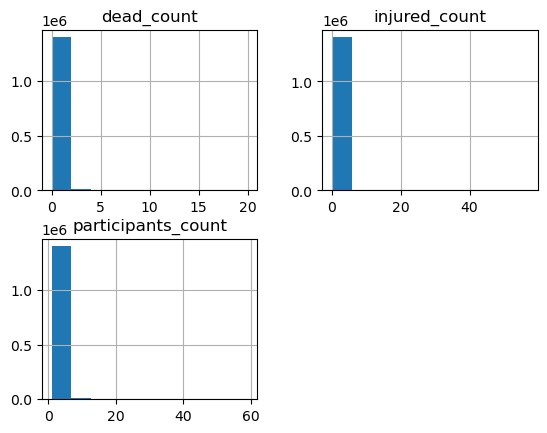

In [8]:
#посмотрим на распределение числовых столбцов
data[['dead_count', 'injured_count', 'participants_count']].hist()
plt.show()

In [13]:
data[['dead_count', 'injured_count', 'participants_count']].describe()

,dead_count,injured_count,participants_count
count,1.411646e+06,1.411646e+06,1.411646e+06
mean,1.125509e-01,1.265948e+00,2.472798e+00
std,3.879114e-01,8.984088e-01,1.181747e+00
min,0.000000e+00,0.000000e+00,1.000000e+00
25%,0.000000e+00,1.000000e+00,2.000000e+00
50%,0.000000e+00,1.000000e+00,2.000000e+00
75%,0.000000e+00,1.000000e+00,3.000000e+00
max,2.000000e+01,5.700000e+01,5.900000e+01


Разброс в данных большой, но нет оснований полагать, что в данных могут быть ошибки. 

In [3]:
#загрузим датасет с информацией об участниках
with open("data_participants.pickle", 'rb') as file:
    data_participants = pickle.load(file)

In [16]:
#изучим данные
first_look_data(data_participants)

,id,role,gender,violations,health_status,years_of_driving_experience
0,2869171,Водитель,Мужской,"[Управление мопедом лицом моложе 16 лет, Управ...",Не пострадал,NaN
1,2320091,Водитель,Мужской,"[Несоблюдение условий, разрешающих движение тр...",Не пострадал,14.0
2,2321011,Водитель,Мужской,[],Не пострадал,25.0
3,2321011,Пассажир,Женский,[Нарушение правил пользования общественным тра...,Не пострадал,NaN
4,2321011,Пассажир,Женский,[],Ранен,NaN


Колонки
Index(['id', 'role', 'gender', 'violations', 'health_status',
       'years_of_driving_experience'],
      dtype='object')
--------------------------------------------------
Содержимое колонок
********************
id
[2869171 2320091 2321011 ... 2382137 2377636 2382295]
1409816
********************
role
['Водитель' 'Пассажир' 'Велосипедист' 'Пешеход'
 'Пешеход, перед ДТП находившийся в (на) ТС в качестве водителя или пешеход, перед ДТП находившийся в (на) ТС в качестве пассажира']
5
********************
gender
['Мужской' 'Женский' None]
2
********************
violations
Списковое исключение
0    [Управление мопедом лицом моложе 16 лет, Управ...
1    [Несоблюдение условий, разрешающих движение тр...
2                                                   []
3    [Нарушение правил пользования общественным тра...
4                                                   []
Name: violations, dtype: object
********************
health_status
['Не пострадал' 'Ранен' 'Скончался']
3
*************

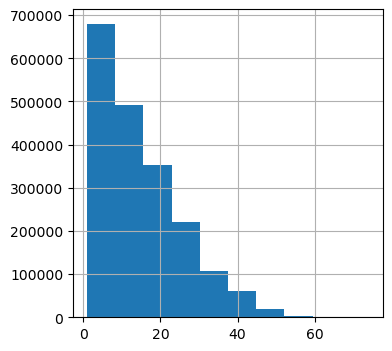

In [18]:
#посмотрим на распределение числовых столбцов
data_participants['years_of_driving_experience'].hist(figsize=(4,4))
plt.show()

In [3]:
#загрузим датасет с информацией о машинах
with open("data_vehicles.pickle", 'rb') as file:
    data_vehicles = pickle.load(file)

In [5]:
#изучим данные
first_look_data(data_vehicles)

,id,year,brand,color,category
0,2869171,2015.0,Прочие марки ТС,Черный,Мопеды с двигателем внутреннего сгорания менее...
1,2320091,2002.0,TOYOTA,Серый,"С-класс (малый средний, компактный) до 4,3 м"
2,2321011,1981.0,DAIMLER,Многоцветный,Одноэтажные длиной от 8 до 12 м
3,2576909,2001.0,HONDA,Серый,"В-класс (малый) до 3,9 м"
4,2576909,1987.0,HONDA,Синий,Мотоциклы


Колонки
Index(['id', 'year', 'brand', 'color', 'category'], dtype='object')
--------------------------------------------------
Содержимое колонок
********************
id
[2869171 2320091 2321011 ... 2377463 2381588 2383542]
1411646
********************
year
[2.015e+03 2.002e+03 1.981e+03 2.001e+03 1.987e+03 2.014e+03 2.003e+03
 2.019e+03 2.007e+03 2.000e+03 1.991e+03 1.994e+03 2.012e+03 1.996e+03
 2.017e+03       nan 2.010e+03 1.983e+03 2.004e+03 1.998e+03 1.992e+03
 2.005e+03 2.008e+03 2.006e+03 1.986e+03 1.999e+03 2.016e+03 2.011e+03
 2.020e+03 1.988e+03 1.993e+03 1.995e+03 2.021e+03 2.022e+03 2.009e+03
 1.997e+03 2.013e+03 1.990e+03 2.018e+03 1.989e+03 1.985e+03 1.978e+03
 1.984e+03 1.982e+03 1.979e+03 1.980e+03 2.023e+03 1.974e+03 1.977e+03
 1.971e+03 1.976e+03 1.965e+03 1.975e+03 1.951e+03 1.963e+03 1.960e+03
 1.968e+03 1.970e+03 1.973e+03 1.000e+00 1.948e+03 1.972e+03 1.962e+03
 1.969e+03 1.958e+03 1.956e+03 1.950e+03 1.966e+03 1.900e+03 1.967e+03
 1.955e+03 1.959e+03 1.964e+03 1

101
********************
Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240533 entries, 0 to 2240532
Data columns (total 5 columns):
 #   Column    Dtype  
---  ------    -----  
 0   id        int32  
 1   year      float64
 2   brand     object 
 3   color     object 
 4   category  object 
dtypes: float64(1), int32(1), object(3)
memory usage: 76.9+ MB
None
--------------------------------------------------
Пропуски
id               0
year        102046
brand        91000
color        63188
category     13044
dtype: int64
--------------------------------------------------


**Вывод:** Данные были собраны и загружены корректно, ошибок в них нет. 

## 4. Исследовательский анализ

In [4]:
#добавим столбцы год 
data['year'] = pd.DatetimeIndex(data['datetime']).year

In [13]:
#найдем количество ДТП по годам
total_accident = data[['id', 'year']].pivot_table(index='year', values='id', aggfunc = 'count') \
                        .reset_index().rename(columns={'id': 'total_accident'})
total_accident['change'] = round((total_accident.shift(-1)['total_accident'] - total_accident['total_accident']) / total_accident['total_accident'] * 100,2)  
total_accident['change'] = total_accident['change'].shift(1)
total_accident

,year,total_accident,change
0,2015,184000,NaN
1,2016,173694,-5.60
2,2017,169432,-2.45
3,2018,168099,-0.79
4,2019,164280,-2.27
5,2020,145382,-11.50
6,2021,136175,-6.33
7,2022,125548,-7.80
8,2023,130257,3.75
9,2024,14779,-88.65


In [14]:
#найдем количество ДТП с погибшими по годам
dead_accident = data[data['dead_count'] > 0].pivot_table(index='year', values='id', aggfunc = 'count') \
                                            .reset_index().rename(columns={'id': 'dead_accident'})
dead_accident['change'] = round((dead_accident.shift(-1)['dead_accident'] - dead_accident['dead_accident']) / dead_accident['dead_accident'] * 100,2)  
dead_accident['change'] = dead_accident['change'].shift(1)
dead_accident

,year,dead_accident,change
0,2015,19624,NaN
1,2016,17176,-12.47
2,2017,16112,-6.19
3,2018,15435,-4.20
4,2019,14454,-6.36
5,2020,13976,-3.31
6,2021,12859,-7.99
7,2022,11977,-6.86
8,2023,12015,0.32
9,2024,1376,-88.55


In [15]:
#найдем количество ДТП с пострадавшими по годам
injured_accident = data[data['injured_count'] > 0].pivot_table(index='year', values='id', aggfunc = 'count') \
                                                .reset_index().rename(columns={'id': 'injured_accident'})
injured_accident['change'] = round((injured_accident.shift(-1)['injured_accident'] - injured_accident['injured_accident']) / injured_accident['injured_accident'] * 100,2)  
injured_accident['change'] = injured_accident['change'].shift(1)
injured_accident

,year,injured_accident,change
0,2015,171641,NaN
1,2016,163096,-4.98
2,2017,159273,-2.34
3,2018,158431,-0.53
4,2019,155311,-1.97
5,2020,136452,-12.14
6,2021,128060,-6.15
7,2022,117926,-7.91
8,2023,122748,4.09
9,2024,13988,-88.60


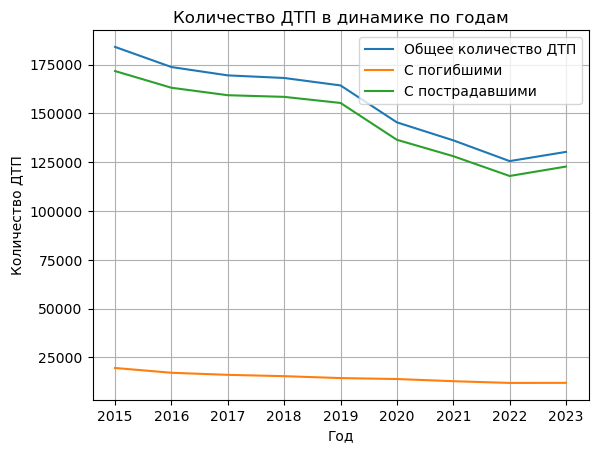

In [20]:
accidents = total_accident.merge(dead_accident, on='year').merge(injured_accident, on='year')
accidents = accidents.drop(['change', 'change_x', 'change_y'], axis=1)
accidents[accidents['year'] <= 2023].plot(x='year')
plt.title('Количество ДТП в динамике по годам')
plt.xlabel('Год')
plt.ylabel('Количество ДТП')
plt.legend(['Общее количество ДТП', 'С погибшими', 'С пострадавшими'], loc='upper right')
plt.grid()
plt.show()

**Вывод:** С 2015г наблюдается нисходящий тренд в количестве ДТП. Особенно значительный спад наблюдается в 2020г - 11.5%. Возможно это связано с пандемией и уменьшением трафика на улицах. В 2023г произошел рост количества ДТП - на 3,75%, в том числе с погибшими (+0,3%) и пострадавшими (+4,1%). Необходимо понять с чем связан этот рост. Возможно это связано с удорожанием обслуживания и ремонта ТС, которое произошло вследствие санкций. 

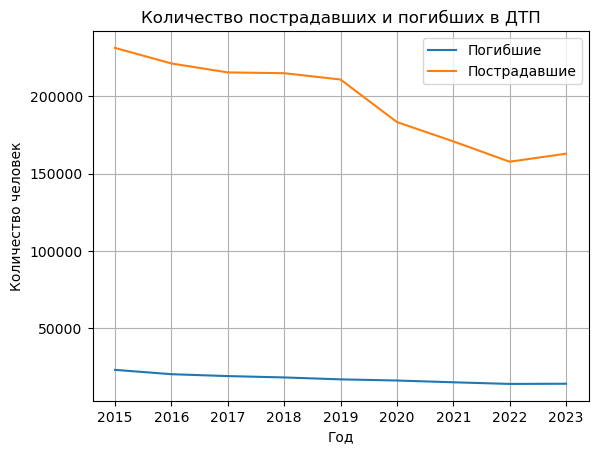

In [31]:
data[data['year'] <= 2023].pivot_table(index='year', values=['dead_count', 'injured_count'], aggfunc = 'sum').reset_index().plot(x='year')
plt.title('Количество пострадавших и погибших в ДТП')
plt.xlabel('Год')
plt.ylabel('Количество человек')
plt.legend(['Погибшие', 'Пострадавшие'])
plt.grid()
plt.show()

**Вывод:** График количества пострадавших и погибших в ДТП также показывает нисходящий тренд до 2022г и рост в 2023г. 

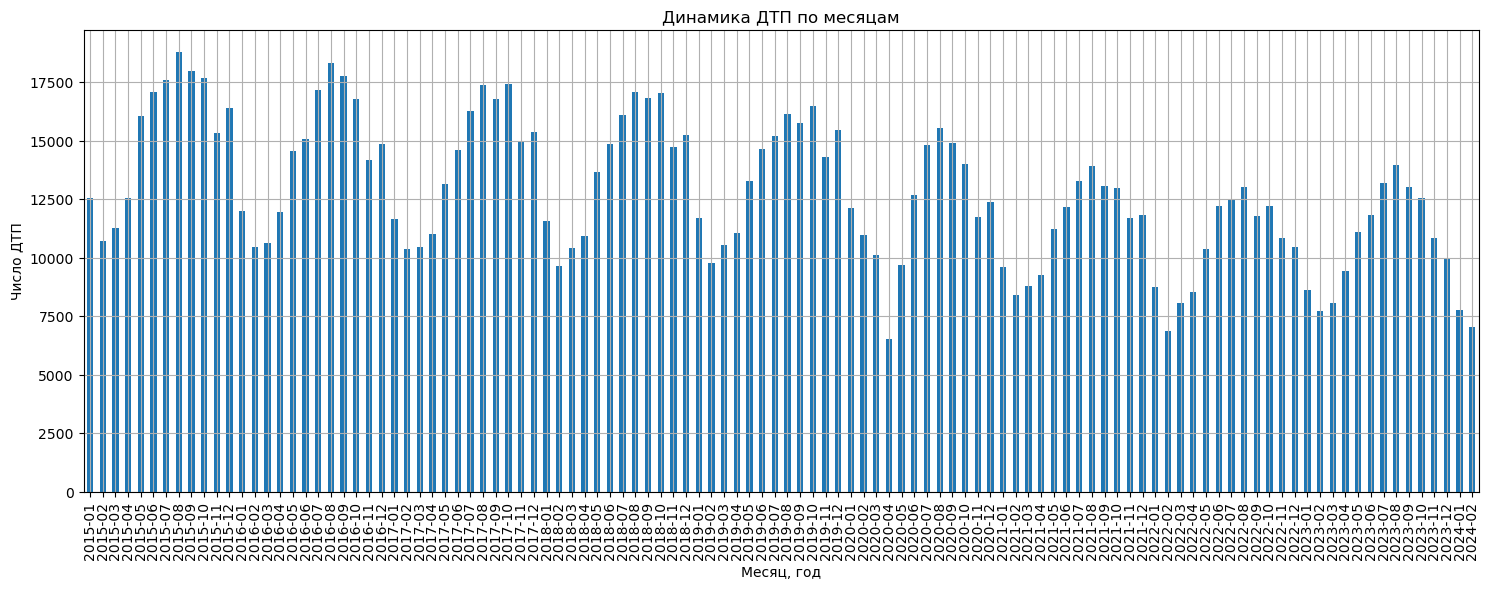

In [42]:
data['datetime'].dt.to_period('M').sort_values().value_counts(sort=False).plot(kind='bar', grid='True', figsize=[18, 6])
plt.title('Динамика ДТП по месяцам')
plt.xlabel('Месяц, год')
plt.ylabel('Число ДТП')
plt.show()

**Вывод:** На графике видна сезонность - самое высокое количество ДТП наблюдаются с июля по сентябрь. Возможно это связано с повышением трафика на улицах в летние месяца. 

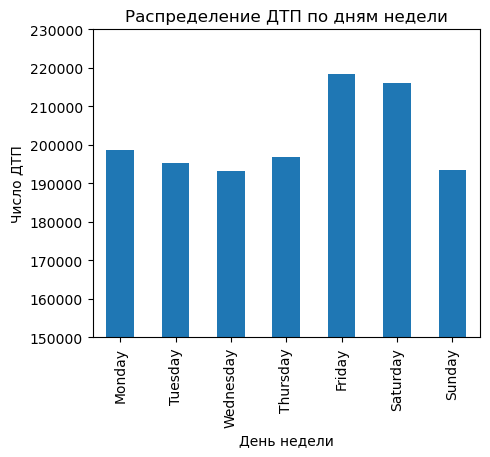

In [6]:
days = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data['weekday'] = data['datetime'].dt.day_name()
data.pivot_table(index='weekday', values='id', aggfunc='count').reindex(days).plot(kind='bar', legend=False, figsize=(5,4))
plt.title('Распределение ДТП по дням недели')
plt.xlabel('День недели')
plt.ylabel('Число ДТП')
plt.ylim(150000, 230000)
plt.show()

**Вывод:** Дни с наибольшим количеством аварий - пятница и суббота. Возможно, это связано с повышением трафика в эти дни или с повышением количества водителей в нетрезвом виде. 

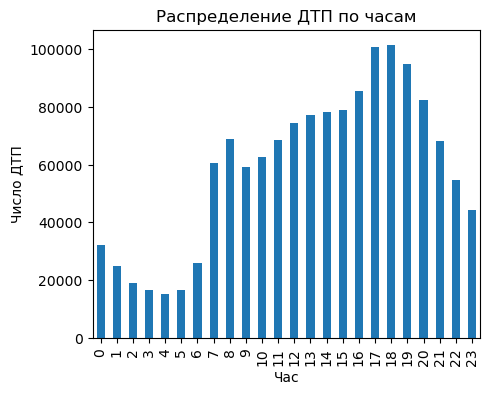

In [7]:
data['hour'] = pd.DatetimeIndex(data['datetime']).hour
data.pivot_table(index='hour', values='id', aggfunc='count').sort_values(by='hour').plot(kind='bar', legend=False, figsize=(5,4))
plt.title('Распределение ДТП по часам')
plt.xlabel('Час')
plt.ylabel('Число ДТП')
plt.show()

**Вывод:** Наибольшее количество аварий наблюдается с 17 до 19 часов. Возможно это опять же связано с повышением трафика на улицах.

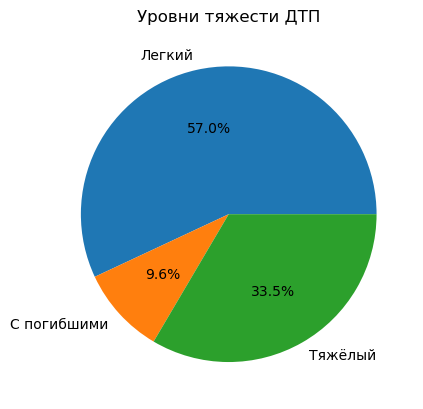

In [37]:
data.groupby('severity')['id'].count().plot(kind='pie', autopct='%1.1f%%')
plt.title('Уровни тяжести ДТП')
plt.ylabel('')
plt.show()

**Вывод:** Больше половины аварий - это аварии лекгой степени тяжести. Треть аварий приходится на аварии тяжелой степени тяжести и почти каждая 10ая авария заканчивается смертельным исходом.

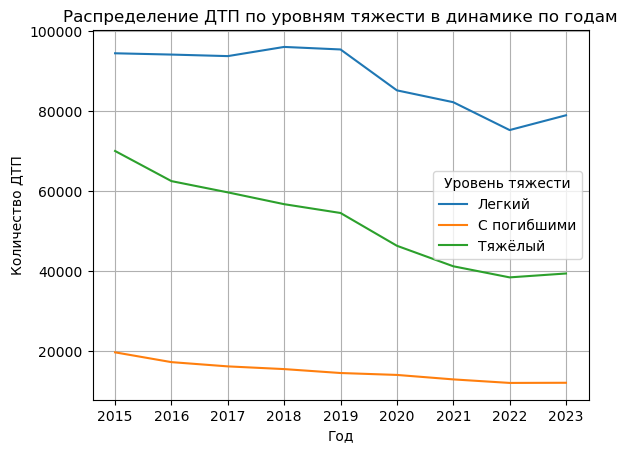

In [11]:
data[data['year'] <= 2023].pivot_table(index='year', columns='severity', values='id', aggfunc='count').reset_index().plot(x='year', grid=True)
plt.title('Распределение ДТП по уровням тяжести в динамике по годам')
plt.xlabel('Год')
plt.ylabel('Количество ДТП')
plt.legend(title='Уровень тяжести')
plt.show()

**Вывод:** Графики в целом повторяют график распределения ДТП по годам. Радует хотя бы то, что среди приросшего числа ДТП в 2023г наибольший рост у аварий легкой степени тяжести. Мы также видим рост среди аварий тяжелой степени тяжести, тогда как число аварий с погибшими осталось почти на прежнем уровне. 

In [44]:
#посмотрим на распределение столбца с категорией ДТП
data.groupby('category')['id'].count().sort_values()

category
Возгорание вследствие технической неисправности движущегося или остановившегося ТС, участвующего в дорожном движении.        79
Наезд на гужевой транспорт                                                                                                  246
Падение груза                                                                                                               273
Наезд на внезапно возникшее препятствие                                                                                     304
Наезд на лицо, не являющееся участником дорожного движения, осуществляющее какую-либо другую деятельность                   650
Наезд на лицо, не являющееся участником дорожного движения, осуществляющее несение службы                                   656
Отбрасывание предмета                                                                                                      1003
Наезд на лицо, не являющееся участником дорожного движения, осуществляющее производство работ  

In [20]:
#категоризируем данные
def category_cat(cat):
    if cat in ['Наезд на пешехода', 'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее производство работ', 'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее несение службы', 'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее какую-либо другую деятельность']:
        return 'Наезд на человека'
    if cat in ['Столкновение', 'Наезд на стоящее ТС']:
        return 'Столкновение'
    if cat in ['Опрокидывание', 'Съезд с дороги']:
        return 'Не справился с управлением'
    if cat in ['Наезд на препятствие', 'Наезд на животное', 'Наезд на гужевой транспорт', 'Наезд на внезапно возникшее препятствие']:
        return 'Наезд на препятствие'
    if cat == 'Наезд на велосипедиста':
        return 'Наезд на велосипедиста'
    return 'Иной вид ДТП'

In [21]:
data['category'] = data['category'].apply(category_cat)

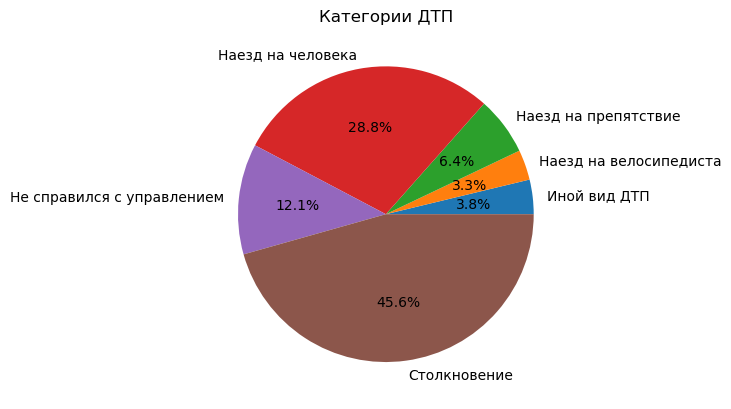

In [23]:
data.groupby('category')['id'].count().plot(kind='pie', autopct='%1.1f%%')
plt.title('Категории ДТП')
plt.ylabel('')
plt.show()

**Вывод:** Почти половина аварий происходит по причине столкновения автомобилей. На втором месте - наезд на человека, такие аварии составляют почти треть от числа ДТП. 12% аварий приходятся на категорию "Не справился с управлением" (съезд с дороги и опрокидывание). 

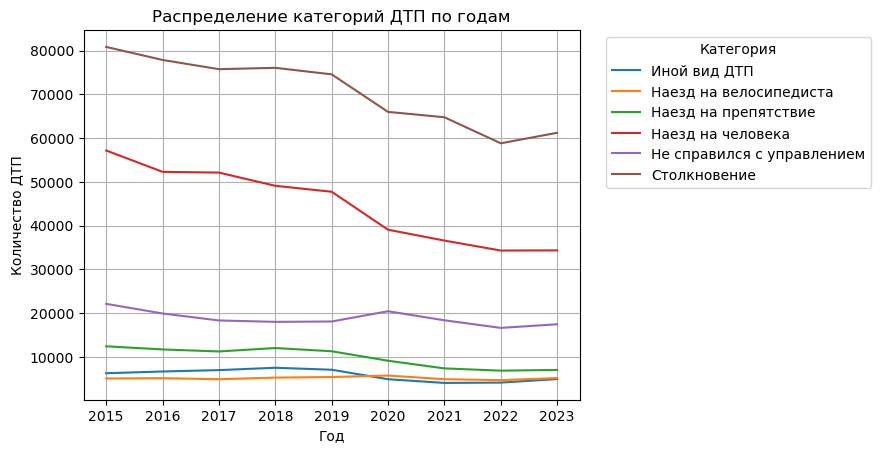

In [24]:
data[data['year'] <= 2023].pivot_table(index='year', columns='category', values='id', aggfunc='count').reset_index().plot(x='year')
plt.title('Распределение категорий ДТП по годам')
plt.xlabel('Год')
plt.ylabel('Количество ДТП')
plt.legend(title='Категория', bbox_to_anchor=(1.04, 1), loc='upper left')
plt.grid()
plt.show()

**Вывод** По всем категориям наблюдается все тот же нисходящий тренд до 2022г, кроме категории "Не сравился с управлением", где заметен значительный рост в 2020г. В 2023г. самый значительный рост наблюдается в категориях "Столкновение" и "Не справился с управлением", что подкрепляет гипотезу о том, что рост ДТП связан с увеличением количества неисправных ТС.  

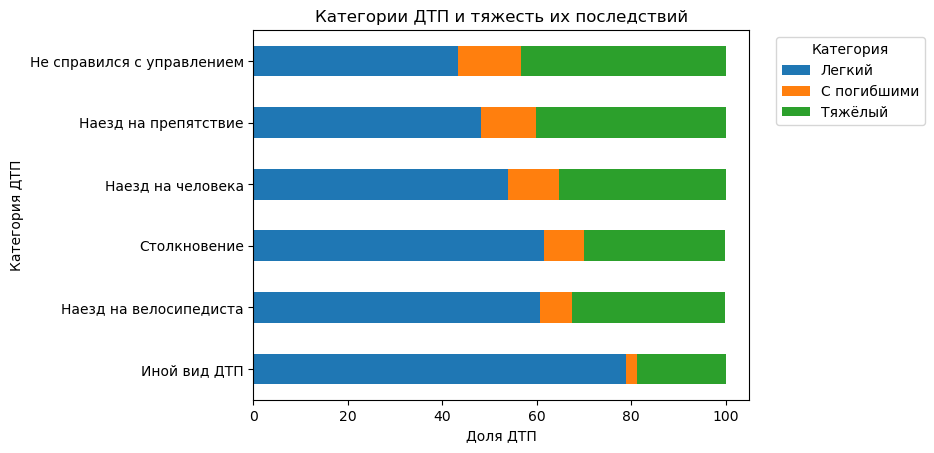

In [22]:
#найдем категории ДТП с наибольшей долей погибших
category_severity = data.pivot_table(index='category', columns='severity', values='id', aggfunc='count')
category_severity['Всего'] = category_severity.sum(axis=1)
category_severity[['Легкий', 'С погибшими', 'Тяжёлый']] = round(category_severity[['Легкий', 'С погибшими', 'Тяжёлый']].div(category_severity['Всего'], axis=0)*100,1)
category_severity = category_severity.drop('Всего', axis=1)
category_severity.sort_values(by='С погибшими').plot(kind='barh', stacked=True)
plt.title('Категории ДТП и тяжесть их последствий')
plt.ylabel('Категория ДТП')
plt.xlabel('Доля ДТП')
plt.legend(title='Категория', bbox_to_anchor=(1.04, 1), loc='upper left')
plt.show()

**Вывод:** Наиболшие доли погибших в категориях "Не справился с управлением", "Наезд на препятствие" и "Наезд на человека"

In [44]:
#развернем столбец с погодой
data_weather = data[['id', 'weather', 'severity']].explode('weather', ignore_index = True)

In [56]:
#посмотрим распределение ДТП по погодным условиям
data_weather.groupby('weather')['id'].count().sort_values(ascending=False)

weather
Ясно                     832870
Пасмурно                 453178
Дождь                     73127
Снегопад                  62524
Туман                      7003
Метель                     5740
Температура ниже -30С      2951
Температура выше +30С      2899
Ураганный ветер             352
Name: id, dtype: int64

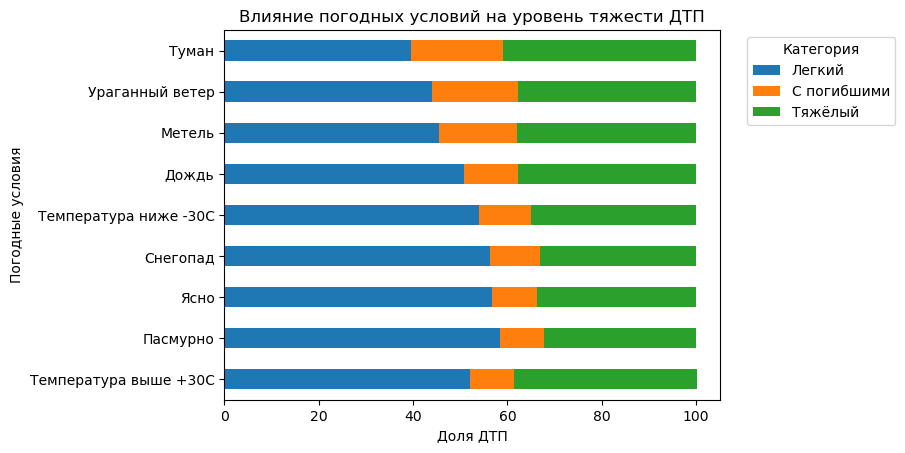

In [74]:
weather_severity = data_weather.pivot_table(index='weather', columns='severity', values='id', aggfunc='count')
weather_severity['Всего'] = weather_severity.sum(axis=1)
weather_severity[['Легкий', 'С погибшими', 'Тяжёлый']] = round(weather_severity[['Легкий', 'С погибшими', 'Тяжёлый']].div(weather_severity['Всего'], axis=0)*100,1)
weather_severity = weather_severity.drop('Всего', axis=1)
weather_severity.sort_values(by='С погибшими').plot(kind='barh', stacked=True)
plt.title('Влияние погодных условий на уровень тяжести ДТП')
plt.ylabel('Погодные условия')
plt.xlabel('Доля ДТП')
plt.legend(title='Категория', bbox_to_anchor=(1.04, 1), loc='upper left')
plt.show()

**Вывод:** Наибольшая доля погибших в ДТП, которые происходят в туман, ураганный ветер и метель.

In [9]:
#посмотрим на распределение столбца light
data.groupby('light')['id'].count()

light
В темное время суток, освещение включено       313170
В темное время суток, освещение не включено     13442
В темное время суток, освещение отсутствует    161442
Не установлено                                     74
Светлое время суток                            883851
Сумерки                                         39667
Name: id, dtype: int64

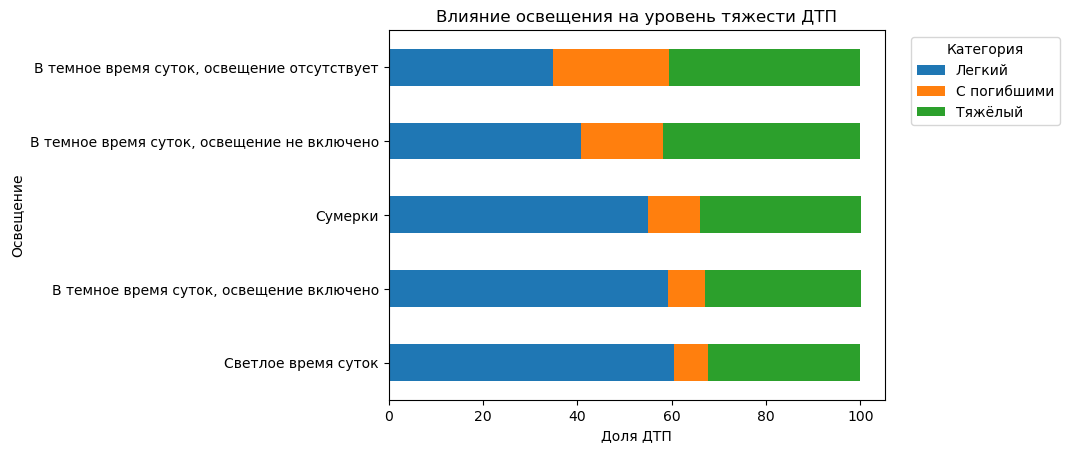

In [18]:
light_severity = data[data['light'] != "Не установлено"].pivot_table(index='light', columns='severity', values='id', aggfunc='count')
light_severity['Всего'] = light_severity.sum(axis=1)
light_severity[['Легкий', 'С погибшими', 'Тяжёлый']] = round(light_severity[['Легкий', 'С погибшими', 'Тяжёлый']].div(light_severity['Всего'], axis=0)*100,1)
light_severity = light_severity.drop('Всего', axis=1)
light_severity.sort_values(by='С погибшими').plot(kind='barh', stacked=True)
plt.title('Влияние освещения на уровень тяжести ДТП')
plt.ylabel('Освещение')
plt.xlabel('Доля ДТП')
plt.legend(title='Категория', bbox_to_anchor=(1.04, 1), loc='upper left')
plt.show()

**Вывод:** Наибольшие доли ДТП с погибшими и с тяжелыми последствиями приходятся на ДТП, которые случились в темное время суток и без освещения. ДТП, которые произошли в темное время суток, но с освещением, имееют гораздо более низкий процент погибших. Необходимо направить больше усилий на обеспечение освещения на дорогах. 

In [23]:
#развернем столбец с дорожными условиями
data_road_cond = data[['id', 'road_conditions', 'severity']].explode('road_conditions', ignore_index = True)

In [59]:
#посмотрим на распределение столбца дорожных условий по тяжести последсвтий ДТП
road_severity = data_road_cond.pivot_table(index='road_conditions', columns='severity', values='id', aggfunc='count')
road_severity['Всего'] = road_severity.sum(axis=1)
road_severity[['Легкий', 'С погибшими', 'Тяжёлый']] = round(road_severity[['Легкий', 'С погибшими', 'Тяжёлый']].div(road_severity['Всего'], axis=0)*100,1)
road_severity.sort_values(by='С погибшими', ascending=False).style.background_gradient().format(precision=1)

severity,Легкий,С погибшими,Тяжёлый,Всего
road_conditions,,,,
Отсутствие направляющих устройств и световозвращающих элементов на них,32.7,24.4,42.9,2191
"Плохая видимость световозвращателей, размещенных на дорожных ограждениях",42.2,22.2,35.5,800
Отсутствие освещения,35.1,21.3,43.6,31494
Недостаточное освещение,37.9,21.3,40.8,4850
Несоответствие железнодорожного переезда предъявляемым требованиям,42.9,20.5,36.6,273
Неисправное освещение,39.2,19.7,41.1,8500
Неудовлетворительное состояние обочин,39.4,17.9,42.7,22995
Отсутствие временных ТСОД в местах проведения работ,45.1,17.9,37.0,3102
Несоответствие дорожных ограждений предъявляемым требованиям,43.9,17.0,39.1,3303


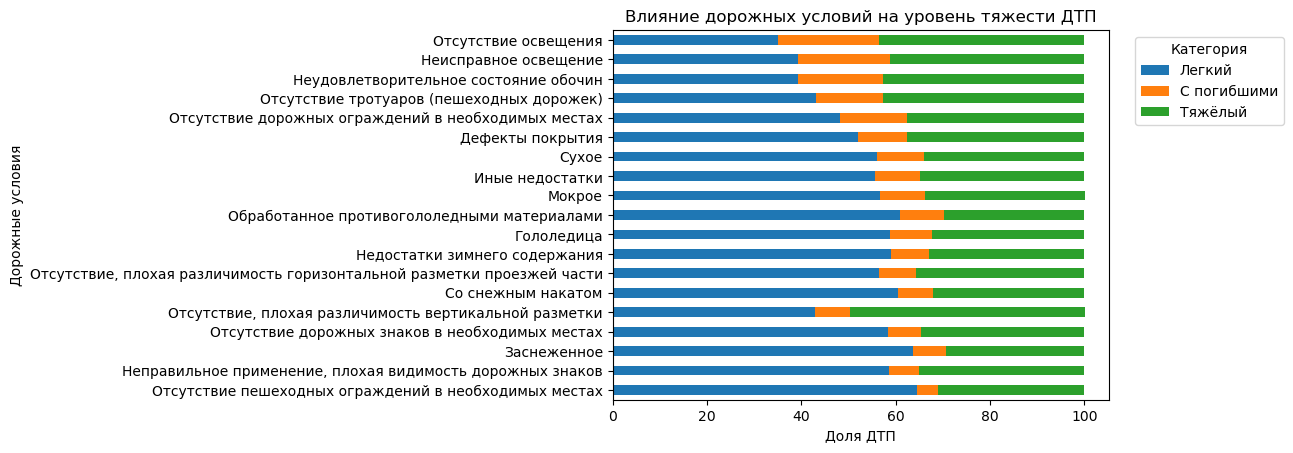

In [56]:
#для графика отберем только крупные категории
road_severity_top = road_severity[road_severity['Всего'] > 8000]
road_severity_top = road_severity_top.drop('Всего', axis=1)
road_severity_top.sort_values(by='С погибшими').plot(kind='barh', stacked=True)
plt.title('Влияние дорожных условий на уровень тяжести ДТП')
plt.ylabel('Дорожные условия')
plt.xlabel('Доля ДТП')
plt.legend(title='Категория', bbox_to_anchor=(1.04, 1), loc='upper left')
plt.show()

**Вывод:** Наибольший процент погибших снова наблюдается в ДТП, которые случились в условиях отсутствия или неисправного освещения. Также в топе по проценту погибших такие категории, как неудовлетворительное состояние обочин, отсутствие тротуаров и дорожных ограждений. Также необходимо отметить, что ДТП в условиях отсутствия или плохой различимости вертикальной разметки в 50% случаев имеют тяжелые последствия. 

In [29]:
#посмотрим на распределение столбца регион по тяжести последсвтий ДТП
region_severity = data.pivot_table(index='parent_region', columns='severity', values='id', aggfunc='count')
region_severity['Всего'] = region_severity.sum(axis=1)
region_severity[['Легкий', 'С погибшими', 'Тяжёлый']] = round(region_severity[['Легкий', 'С погибшими', 'Тяжёлый']].div(region_severity['Всего'], axis=0)*100,1)
region_severity.sort_values(by=['С погибшими', 'Тяжёлый'], ascending=True).style.background_gradient().format(precision=1)

severity,Легкий,С погибшими,Тяжёлый,Всего
parent_region,,,,
Санкт-Петербург,64.1,3.6,32.3,52019
Москва,71.7,4.6,23.7,80195
Севастополь,77.9,5.9,16.2,5339
Омская область,71.6,6.1,22.3,25236
Тюменская область,81.0,6.3,12.7,24497
Ивановская область,69.1,6.3,24.6,11536
Мурманская область,66.3,6.3,27.4,7251
Нижегородская область,70.5,6.9,22.7,46241
Республика Коми,62.4,6.9,30.6,9170


**Вывод:** Среди регионов с самой большой долей ДТП с погибшими и тяжелыми последствиями находятся Чеченская Республика, Республика Ингушетия, Кабардино-Балкарская Республика и Республика Дагестан. Регионы с наименьшей долей ДТП с погибшими и тяжелыми последствиями - Тюменская область, Севастополь, Амурская и Кировские области и Москва. Наименьшая доля ДТП с погибшими в Санкт-Петербурге. 

In [4]:
#развернем столбец с нарушениями
data_violations = data_participants.explode('violations', ignore_index = True)
data_violations.head()

,id,role,gender,violations,health_status,years_of_driving_experience
0,2869171,Водитель,Мужской,Управление мопедом лицом моложе 16 лет,Не пострадал,NaN
1,2869171,Водитель,Мужской,"Управление ТС лицом, не имеющим права на управ...",Не пострадал,NaN
2,2869171,Водитель,Мужской,Оставление места ДТП,Не пострадал,NaN
3,2869171,Водитель,Мужской,Невыполнение требований обеспечения безопаснос...,Не пострадал,NaN
4,2320091,Водитель,Мужской,"Несоблюдение условий, разрешающих движение тра...",Не пострадал,14.0


In [24]:
data_violations['violations'].unique()

array(['Управление мопедом лицом моложе 16 лет',
       'Управление ТС лицом, не имеющим права на управление ТС',
       'Оставление места ДТП',
       'Невыполнение требований обеспечения безопасности при начале движения',
       'Несоблюдение условий, разрешающих движение транспорта задним ходом',
       nan, 'Нарушение правил пользования общественным транспортом',
       'Несоблюдение очередности проезда',
       'Выезд на полосу встречного движения',
       'Нарушение правил проезда пешеходного перехода',
       'Движение во встречном направлении по дороге с односторонним движением',
       'Управление ТС в состоянии алкогольного опьянения',
       'Другие нарушения ПДД водителем', 'Несоблюдение требований ОСАГО',
       'Неправильный выбор дистанции',
       'Эксплуатация незарегистрированного ТС',
       'Нарушение требований сигналов светофора',
       'Нарушение правил перестроения',
       'Нарушение правил проезда ж/д переездов',
       'Выезд на полосу встречного движения с 

In [8]:
#посмотрим на топ 15 нарушений по доле погибших
violations_severity = data_violations.pivot_table(index='violations', columns='health_status', values='id', aggfunc='count')
violations_severity['Всего'] = violations_severity.sum(axis=1)
violations_severity[['Не пострадал', 'Ранен', 'Скончался']] = round(violations_severity[['Не пострадал', 'Ранен', 'Скончался']].div(violations_severity['Всего'], axis=0)*100,1)
violations_severity.sort_values(by='Скончался', ascending=False).head(15).style.background_gradient().format(precision=1)

health_status,Не пострадал,Ранен,Скончался,Всего
violations,,,,
Ходьба вдоль проезжей части попутного направления вне населенного пункта при удовлетворительном состоянии обочины,0.5,53.0,46.5,2756.0
Отсутствие световозвращающих элементов,0.7,53.2,46.1,7419.0
Движение вдоль проезжей части попутного направления вне населенного пункта при удовлетворительном состоянии обочины,0.5,54.5,45.0,4804.0
Пешеход в состоянии наркотического опьянения,nan,57.4,42.6,94.0
Нахождение на проезжей части без цели её перехода,0.7,63.0,36.3,19496.0
Пешеход в состоянии алкогольного опьянения,0.3,67.3,32.4,17072.0
Переход проезжей части в запрещённом месте (оборудованном пешеходными ограждениями),0.1,68.7,31.2,2402.0
"Управление велосипедом, не оснащённым светоотражающими элементами",0.8,72.2,27.0,1694.0
Нарушение правил проезда ж/д переездов,16.0,57.5,26.5,1042.0


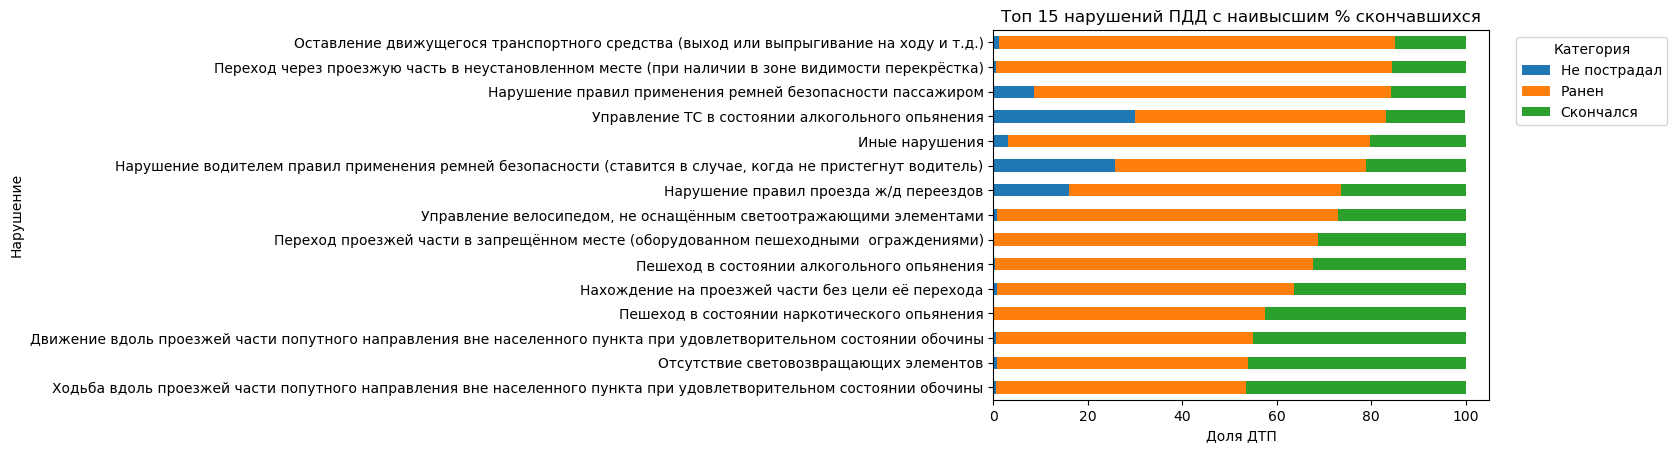

In [18]:
violations_sev = violations_severity.drop('Всего', axis=1)
violations_sev.sort_values(by='Скончался', ascending=False).head(15).plot(kind='barh', stacked=True)
plt.title('Топ 15 нарушений ПДД с наивысшим % скончавшихся')
plt.ylabel('Нарушение')
plt.xlabel('Доля ДТП')
plt.legend(title='Категория', bbox_to_anchor=(1.04, 1), loc='upper left')
plt.show()

**Вывод:** Топ 7 нарушений с самой высокой долей погибших и раненных относятся к нарушению со стороны пешеходов. В Топ 15 нарушений также попали управление велосипедом без светоотражающих элементов, нарушение правил переезда ж/д переездов, езда без ремня безопасности, езда в состоянии алкогольного опьянения. 

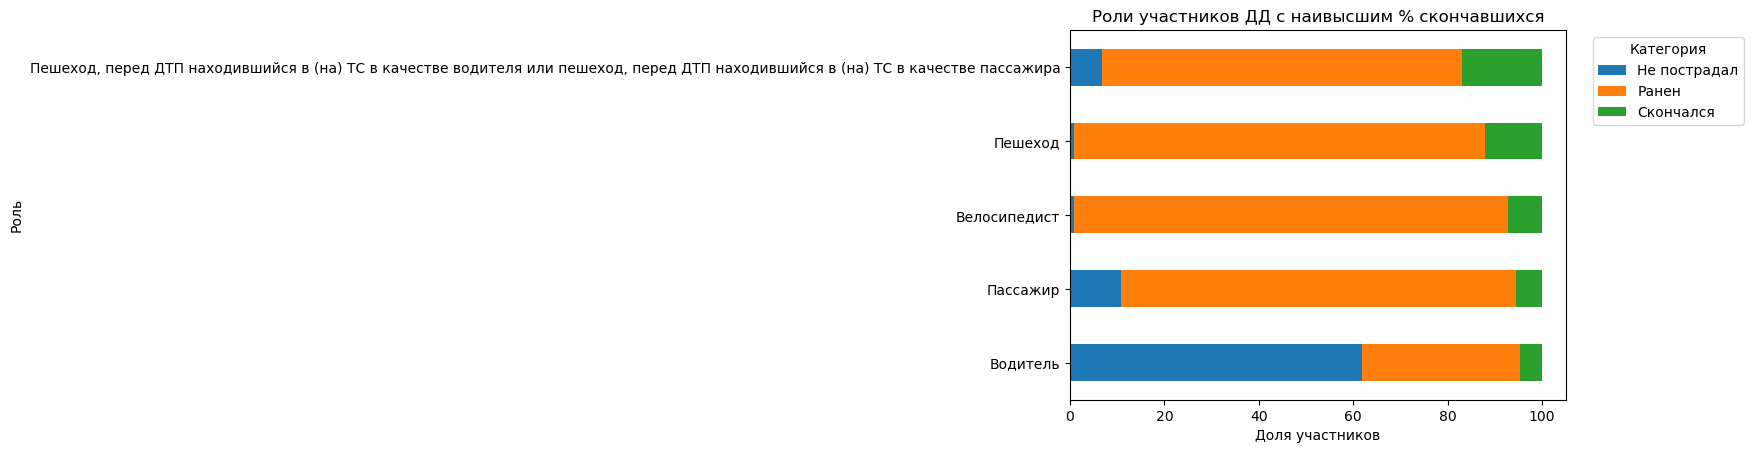

In [20]:
violations_role = data_violations.pivot_table(index='role', columns='health_status', values='id', aggfunc='count')
violations_role['Всего'] = violations_role.sum(axis=1)
violations_role[['Не пострадал', 'Ранен', 'Скончался']] = round(violations_role[['Не пострадал', 'Ранен', 'Скончался']].div(violations_role['Всего'], axis=0)*100,1)
violations_role = violations_role.drop('Всего', axis=1)
violations_role.sort_values(by='Скончался').plot(kind='barh', stacked=True)
plt.title('Роли участников ДД с наивысшим % скончавшихся')
plt.ylabel('Роль')
plt.xlabel('Доля участников')
plt.legend(title='Категория', bbox_to_anchor=(1.04, 1), loc='upper left')
plt.show()

**Вывод:** Наибольшая доля погибших и ранныеных приходится на пешеходов и велосипедистов. Более строгие правила ДД для этих категорий участников и более строгий их контроль, а также создание безопасных зон (велосипедные дорожки, ограждения) могут помочь снизить количество пострадавших. Интересно, что среди пассажиров не пострадали только менее 15% категории, тогда как у водителей это число достигает 60%.

In [26]:
#посмотрим на топ нарушений среди пассажиров
data_violations[data_violations['role'] == "Пассажир"]['violations'].value_counts()

Нарушение правил применения ремней безопасности пассажиром                               41998
Иные нарушения                                                                           12964
Нарушение правил пользования общественным транспортом                                    12621
Нарушение правил применения мотошлема пассажиром                                          8075
Оставление движущегося транспортного средства (выход или выпрыгивание на ходу и т.д.)      950
Передача управления ТС лицу, находящемуся в состоянии опьянения                            438
Создание помех для водителя в управлении транспортным средством                            326
Name: violations, dtype: int64

**Вывод:** Более 50% нарушений со стороны пассажира - езда без ремня безопасности. Более строгие штрафы за езду без ремня для пассажиров могут помочь снизить количество пострадавших.

In [31]:
violations_gender = data_violations[data_violations['role'] == "Водитель"].pivot_table(index='gender', columns='health_status', values='id', aggfunc='count')
violations_gender['Всего'] = violations_gender.sum(axis=1)
violations_gender[['Не пострадал', 'Ранен', 'Скончался']] = round(violations_gender[['Не пострадал', 'Ранен', 'Скончался']].div(violations_gender['Всего'], axis=0)*100,1)
violations_gender.sort_values(by='Скончался', ascending=False)

health_status,Не пострадал,Ранен,Скончался,Всего
gender,,,,
Мужской,62.4,32.8,4.7,2594436
Женский,54.5,43.4,2.1,392279


**Вывод:** Погибших среди женщин водителей меньше в более чем 2 раза, чем среди водителей мужчин. При этом в целом мужчины чаще выходят из ДТП без последствий. Можно все же предположить, что женщины более осторожны на дорогах и реже попадают в тяжелые ДТП. 

In [42]:
#создадим функцию деления водителей на новичков (0-3), опытных водителей(3-40) и водителей в возрасте(>40)
def driving(year):
    if year <= 3:
        return 1
    if 3<year<=40:
        return 2
    if year>40:
        return 3

In [43]:
data_violations['experience'] = data_violations['years_of_driving_experience'].apply(driving)

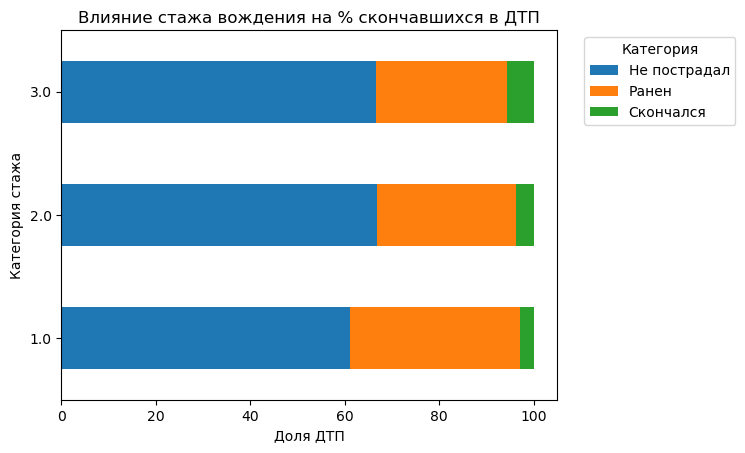

In [45]:
experience = data_violations.pivot_table(index='experience', columns='health_status', values='id', aggfunc='count')
experience['Всего'] = experience.sum(axis=1)
experience = round(experience.div(experience['Всего'], axis=0)*100,1).drop('Всего', axis=1)
experience.sort_values(by='Скончался').plot(kind='barh', stacked=True)
plt.title('Влияние стажа вождения на % скончавшихся в ДТП')
plt.ylabel('Категория стажа')
plt.xlabel('Доля ДТП')
plt.legend(title='Категория', bbox_to_anchor=(1.04, 1), loc='upper left')
plt.show()

**Вывод:** Наибольший % погибших среди водителей со стажем более 40 лет. Наименьший % погибших - среди водителей новичков, со стажем менее 3 лет. При этом % раненых среди новичков самый большой. Можно предположить, что они осторожны на дорогах и реже попадают в тяжелые аварии, но в силу малого опыта чаще попадают в аварии в целом. 

Проверим предположение о том, что увеличение количества ДТП в 2023г. связано с удорожанием обслуживания и ремонта автомобилей, последовавшего как результат санкций. Проверим, увеличилось ли количество ДТП связанных с технически неисправными ТС. 

In [28]:
tech_issues = data_violations[(data_violations['violations'] == "Эксплуатация ТС с техническими неисправностями, при которых запрещается их эксплуатация") | (data_violations['violations'] == "Управление транспортным средством при наличии неисправностей или условий, при которых эксплуатация транспортного средства запрещена") | (data_violations['violations'] == "Эксплуатация технически неисправного ТС (проставляется в случае ДТП по причине технеисправности)")]

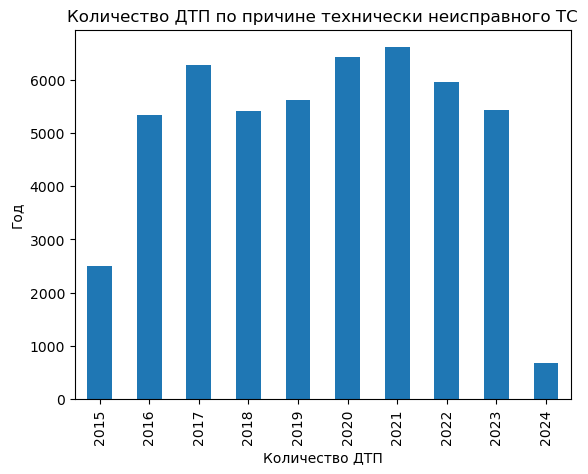

In [59]:
data[['id', 'year']].merge(tech_issues['id'], on='id').pivot_table(index='year', values='id', aggfunc='nunique').plot(kind='bar', legend=False)
plt.title('Количество ДТП по причине технически неисправного ТС')
plt.ylabel('Год')
plt.xlabel('Количество ДТП')
plt.show()

**Вывод:** Как видим на графике, количество ДТП, связанных с неисправностью ТС, в 2022 и 2023г. уменьшилось, следовательно нельзя сказать, что это является причиной роста количества ДТП в 2023г. При этом данные не позволяют нам достоверно оценить изменения в количестве неисправных авто на дорогах и их влияние на количество ДТП.

## 5. Проверка предположений

### 5.1. Марка автомобиля
Проверим предположение, что российские марки ТС представляют больше опасности на дорогах, чем иностранные марки.

In [76]:
#заполним пропуски в столбце brand
data_vehicles['brand']=data_vehicles['brand'].fillna('').apply(str)

In [77]:
#найдем российские марки ТС
r = re.compile("[а-яА-Я]+")
brands = data_vehicles['brand'].unique().tolist()
russian = [b for b in filter(r.match, brands)]

In [78]:
#создадим функию категоризации ТС на российские и иностранные
def brand(b):
    if b in russian:
        if 'Прочие' in b:
            return ''
        return 1         
    return 0

In [79]:
data_vehicles['brand_country'] = data_vehicles['brand'].apply(brand)

In [80]:
#оставим только российские(1) и иностранные ТС(0)
data_vehicles = data_vehicles[(data_vehicles['brand_country'] == 1) | (data_vehicles['brand_country'] == 0)]

In [81]:
#посмортим на распределение
data_vehicles.groupby('brand_country')['id'].count()

brand_country
0    1446750
1     700948
Name: id, dtype: int64

In [82]:
cars = data_vehicles[['id', 'brand_country']]

In [83]:
#избавимся от дубликатов
cars = cars.drop_duplicates().reset_index(drop=True)

In [84]:
#найдем аварии с участием и российских, и иностранных ТС
cars.groupby('id').agg({'brand_country': 'nunique'}).query('brand_country > 1').count()

brand_country    268156
dtype: int64

In [85]:
#удалим такие случаи и оставаим только аварии с участием либо российского, либо иностранного ТС
two_cars = cars.groupby('id').agg({'brand_country': 'nunique'}).query('brand_country > 1').reset_index()['id'].tolist()

In [86]:
cars = cars.query('id not in @two_cars')

In [87]:
#посмортим на распределение
cars['brand_country'].value_counts()

0    780777
1    326835
Name: brand_country, dtype: int64

In [88]:
#добавим информацию о количестве погибших из основного датасета
cars = cars.merge(data[['id', 'dead_count']], on='id', how='left')

In [89]:
#посчитаем среднее количество погибших в ДТП с российскими и иностранными ТС
cars.pivot_table(index='brand_country', values='dead_count', aggfunc=['count', 'sum', 'mean'])

,count,sum,mean
,dead_count,dead_count,dead_count
brand_country,,,
0,780777,77471.0,0.099223
1,326835,42897.0,0.131250


In [90]:
#посчтиаем долю ДТП с погибшими
cars_rus = cars[cars['brand_country'] == 0]
cars_for = cars[cars['brand_country'] == 1]
rus_dead = cars_rus[cars_rus['dead_count'] != 0]
for_dead = cars_for[cars_for['dead_count'] != 0]

print('Доля ДТП с погибшими с участием ТС российских марок:',round(len(rus_dead)/len(cars_rus),2))
print('Доля ДТП с погибшими с участием ТС иностранных марок:', round(len(for_dead)/len(cars_for),2))

Доля ДТП с погибшими с участием ТС российских марок: 0.09
Доля ДТП с погибшими с участием ТС иностранных марок: 0.12


In [47]:
#посмотрим есть ли связть между страной производства ТС и количеством погибших
cars[['brand_country', 'dead_count']].corr(method= 'spearman')

,brand_country,dead_count
brand_country,1.000000,0.046373
dead_count,0.046373,1.000000


**Вывод:** Доля погибших в ДТП с участием российских марок и иностранных марок различается слабо - 9% и 12%. Связь между маркой ТС и количеством погибших очень слабая. 

Применим проверку z-критерием, чтобы узнать есть ли статистически значимая разница в долях ДТП с погибшими с участием ТС российских марок и иностранных марок.

Формулируем гипотезы:

- Нулевая гипотеза: доля ДТП с погибшими с участием ТС российских марок не превышает долю ДТП с погибшими с участием ТС иностранных марок
- Альтернативная гипотеза: доля ДТП с погибшими с участием ТС российских марок выше доли ДТП с участием ТС иностранных марок, различия статистически значимы

In [91]:
alpha = .05 

dead = np.array([len(rus_dead), len(for_dead)])
all_part = np.array([len(cars_rus),len(cars_for)])

In [92]:
def z_test(successes, trials, alpha):

  
    alpha = alpha
    successes = successes
    trials = trials

    # пропорция успехов в первой группе:
    p1 = successes[0] / trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1] / trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) *
                                    (1 / trials[0] + 1 / trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) # гипотеза односторонняя поэтому без 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print('Не получилось отвергнуть нулевую гипотезу')

In [93]:
z_test(dead, all_part, alpha)

p-значение:  0.0
Отвергаем нулевую гипотезу


**Вывод:** Статистически значимая разница между долями ДТП с погибшими с участием ТС российских марок и иностранных марок есть. Соответственно можно сказать, что ТС российских марок представляет большую опасность на дорогах, чем ТС иностранных марок, однако на количество погибших влияют и другие факторы.

### 5.2. Транспортная реформа в СПБ 

Оценим влияние транспортной реформы в СПБ, реализованнаую в 2022г, в рамках которой были изменены маршруты автобусов, произведена замена автобусов на более современные и были убраны с дорог маршрутки. Проверим предположение, что количество аварий в СПб после реформы снизилось.

In [13]:
#выделим датасет по СПБ
spb = data[data['parent_region'] == "Санкт-Петербург"].reset_index(drop=True)

In [14]:
#найдем количество ДТП по годам
total = spb[['id', 'year']].pivot_table(index='year', values='id', aggfunc = 'count') \
                        .reset_index().rename(columns={'id': 'total_accident'})
total['change'] = round((total.shift(-1)['total_accident'] - total['total_accident']) / total['total_accident'] * 100,2)  
total['change'] = total['change'].shift(1)
total

,year,total_accident,change
0,2015,7243,NaN
1,2016,6104,-15.73
2,2017,6311,3.39
3,2018,6463,2.41
4,2019,6634,2.65
5,2020,5232,-21.13
6,2021,5048,-3.52
7,2022,4280,-15.21
8,2023,4195,-1.99
9,2024,509,-87.87


In [15]:
#найдем количество ДТП с погибшими по годам
dead = spb[spb['dead_count'] > 0].pivot_table(index='year', values='id', aggfunc = 'count') \
                                            .reset_index().rename(columns={'id': 'dead_accident'})
dead['change'] = round((dead.shift(-1)['dead_accident'] - dead['dead_accident']) / dead['dead_accident'] * 100,2)  
dead['change'] = dead['change'].shift(1)
dead

,year,dead_accident,change
0,2015,328,NaN
1,2016,225,-31.40
2,2017,232,3.11
3,2018,213,-8.19
4,2019,208,-2.35
5,2020,212,1.92
6,2021,193,-8.96
7,2022,137,-29.02
8,2023,127,-7.30
9,2024,9,-92.91


In [16]:
#найдем количество ДТП с пострадавшими по годам
injured = spb[spb['injured_count'] > 0].pivot_table(index='year', values='id', aggfunc = 'count') \
                                                .reset_index().rename(columns={'id': 'injured_accident'})
injured['change'] = round((injured.shift(-1)['injured_accident'] - injured['injured_accident']) / injured['injured_accident'] * 100,2)  
injured['change'] = injured['change'].shift(1)
injured

,year,injured_accident,change
0,2015,6996,NaN
1,2016,5938,-15.12
2,2017,6135,3.32
3,2018,6301,2.71
4,2019,6497,3.11
5,2020,5078,-21.84
6,2021,4898,-3.54
7,2022,4171,-14.84
8,2023,4096,-1.80
9,2024,501,-87.77


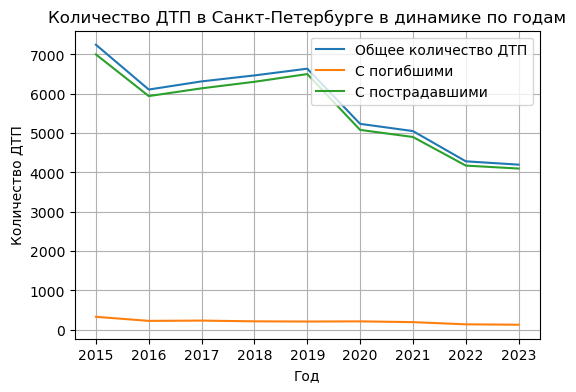

In [17]:
spb_accidents = total.merge(dead, on='year').merge(injured, on='year')
spb_accidents = spb_accidents.drop(['change', 'change_x', 'change_y'], axis=1)
spb_accidents[spb_accidents['year'] <= 2023].plot(x='year', figsize = (6,4))
plt.title('Количество ДТП в Санкт-Петербурге в динамике по годам')
plt.xlabel('Год')
plt.ylabel('Количество ДТП')
plt.legend(['Общее количество ДТП', 'С погибшими', 'С пострадавшими'], loc='upper right')
plt.grid()
plt.show()

**Вывод:** В 2022г. количество ДТП с СПБ снизилось на 15%, в том числе ДТП с погибшими снизилось на 29% и с пострадавшими на 15%. В отличие от статистики по всем региоам в целом, где в 2023г. наблюдался рост ДТП, в Санкт-Петербурге мы наблюдаем снижение в количестве ДТП на 2%, в том числе с погибшими на 7,3% и пострадавшими на 1,8%. 

In [73]:
#посмотрим категории ТС
data_vehicles['category'].unique()

array(['С-класс (малый средний, компактный) до 4,3 м',
       'Одноэтажные длиной от 8 до 12 м', 'В-класс (малый) до 3,9 м',
       'Мотоциклы', 'Одноэтажные длиной от 5 до 8 м',
       'D-класс (средний) до 4,6 м', 'Велосипеды', 'Подвижной состав ж/д',
       'Персональное электрическое средство передвижения малой мощности',
       'Бортовые грузовые автомобили', 'Цистерны',
       'Одноэтажные длиной не более 5 м',
       'Е-класс (высший средний, бизнес-класс) до 4,9 м', 'Фургоны',
       'Минивэны и универсалы повышенной вместимости', 'Седельные тягачи',
       'Трамваи', 'Прочая спецтехника', 'Прочие легковые автомобили',
       'А-класс (особо малый) до 3,5 м', 'Прочие грузовые автомобили',
       'Оснащённые специализированным оборудованием автотранспортные средства аварийно-спасательных служб и полиции',
       'Автомобили скорой медицинской помощи', 'Самосвалы',
       'Автокраны и транспортные средства, оснащенные кранами-манипуляторами',
       'Троллейбусы', 'Автоцементовоз

In [6]:
#выделим городской транспорт
bus_cat= ['Одноэтажные длиной от 8 до 12 м', 'Одноэтажные длиной от 5 до 8 м', 'Одноэтажные длиной не более 5 м', 'Трамваи', 'Троллейбусы', 'Школьные автобусы', 'Автобусы (без типа)']
bus = data_vehicles.query('category in @bus_cat').reset_index(drop=True)

In [17]:
#добавим городской транспорт к основному датасету
bus_spb = bus.merge(spb[['id', 'year', 'dead_count', 'injured_count', 'severity']], on='id')

In [157]:
#посмотрим на бренды
bus_spb['brand'].unique()

array(['', 'НефАЗ', 'ПАЗ', 'ГАЗ', 'ЛИАЗ', 'TROLL', 'YUTONG', 'ЗИД', 'MAN',
       'PAYKAN', 'МАЗ', 'SCANIA', 'МАЗ-МАН', 'ВАЗ', 'KIA', 'VOLVO',
       'КАМАЗ', 'ВОСХОД', 'HYUNDAI', 'DAF', 'FORD', 'MERCEDES', 'ГОЛАЗ',
       'FIAT', 'NEOPLAN', 'SETRA', 'VOLKSWAGEN', 'КАВЗ', 'KING LONG',
       'ISUZU', 'HIGER', 'NISSAN', 'IVECO', 'TOYOTA', 'SHEN LONG',
       'PEUGEOT', 'LOTUS', 'БАЗ', 'ВИС', 'AC', 'ЗИЛ', 'ATK', 'LDV', 'JAC',
       'ЛАЗ', 'KTM', 'ZONDA', 'GOLDEN DRAGON', 'УАЗ', 'BOVA', 'SSANGYONG',
       'HOLDEN', 'RENAULT', 'MG', 'ADMIRAL', 'ASIA', 'ABM', 'CHEVROLET',
       'LTI', 'КРАЗ', 'MARCOS', 'CITROEN', 'SOLO', 'LAVERDA', 'УРАЛ',
       'HUMMER', 'FREIGHTLINER', 'BM', 'LIFAN'], dtype=object)

In [18]:
#уберем данные с пропусками
bus_spb = bus_spb[bus_spb['brand'] != ""].reset_index(drop=True)

In [158]:
bus_spb.groupby('brand')['id'].count().sort_values(ascending=False).head(15)

brand
ПАЗ              1165
ЛИАЗ              930
                  438
МАЗ               244
НефАЗ             215
МАЗ-МАН           183
VOLKSWAGEN        115
MERCEDES          106
ГАЗ               102
GOLDEN DRAGON      48
YUTONG             45
IVECO              40
SCANIA             27
FORD               24
ЗИД                23
Name: id, dtype: int64

In [19]:
#исключим из данных МАЗ-МАН, так как это марка производящая грузовые ТС
bus_spb = bus_spb[bus_spb['brand'] != "МАЗ-МАН"].reset_index(drop=True)

In [20]:
bus_spb = bus_spb.rename(columns={'year_x': 'prod_year', 'year_y':'year'})

In [21]:
#посмотрим на количество ДТП с транспортом по годам
total_bus = bus_spb.pivot_table(index='year', values='id', aggfunc = 'count') \
                        .reset_index().rename(columns={'id': 'total_accident'})
total_bus['change'] = round((total_bus.shift(-1)['total_accident'] - total_bus['total_accident']) / total_bus['total_accident'] * 100,2)  
total_bus['change'] = total_bus['change'].shift(1)
total_bus

,year,total_accident,change
0,2015,763,NaN
1,2016,743,-2.62
2,2017,678,-8.75
3,2018,726,7.08
4,2019,749,3.17
5,2020,398,-46.86
6,2021,408,2.51
7,2022,254,-37.75
8,2023,242,-4.72
9,2024,33,-86.36


In [22]:
#найдем количество ДТП с погибшими по годам
dead_bus = bus_spb[bus_spb['dead_count'] > 0].pivot_table(index='year', values='id', aggfunc = 'count') \
                                            .reset_index().rename(columns={'id': 'dead_accident'})
dead_bus['change'] = round((dead_bus.shift(-1)['dead_accident'] - dead_bus['dead_accident']) / dead_bus['dead_accident'] * 100,2)  
dead_bus['change'] = dead_bus['change'].shift(1)
dead_bus

,year,dead_accident,change
0,2015,24,NaN
1,2016,19,-20.83
2,2017,16,-15.79
3,2018,20,25.00
4,2019,28,40.00
5,2020,19,-32.14
6,2021,17,-10.53
7,2022,6,-64.71
8,2023,6,0.00
9,2024,1,-83.33


In [23]:
#найдем количество ДТП с пострадавшими по годам
injured_bus = bus_spb[bus_spb['injured_count'] > 0].pivot_table(index='year', values='id', aggfunc = 'count') \
                                                .reset_index().rename(columns={'id': 'injured_accident'})
injured_bus['change'] = round((injured_bus.shift(-1)['injured_accident'] - injured_bus['injured_accident']) / injured_bus['injured_accident'] * 100,2)  
injured_bus['change'] = injured_bus['change'].shift(1)
injured_bus

,year,injured_accident,change
0,2015,746,NaN
1,2016,727,-2.55
2,2017,665,-8.53
3,2018,710,6.77
4,2019,732,3.10
5,2020,385,-47.40
6,2021,395,2.60
7,2022,248,-37.22
8,2023,237,-4.44
9,2024,32,-86.50


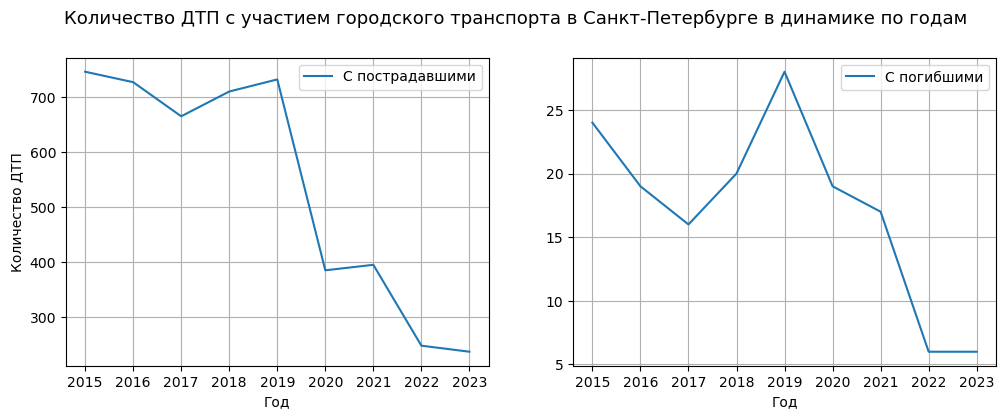

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
fig.suptitle('Количество ДТП с участием городского транспорта в Санкт-Петербурге в динамике по годам', y=1, fontsize=13)
injured_bus = injured_bus.drop('change', axis=1)
injured_bus[injured_bus['year'] <= 2023].plot(x='year', ax=ax1)
ax1.set_xlabel('Год')
ax1.set_ylabel('Количество ДТП')
ax1.legend(['С пострадавшими'])
ax1.grid()

dead_bus = dead_bus.drop('change', axis=1)
dead_bus[dead_bus['year'] <= 2023].plot(x='year', ax=ax2)
ax2.set_xlabel('Год')
ax2.legend(['С погибшими'])
ax2.grid()
plt.show()

**Вывод:** Количество ДТП с участием городского транспорта с пострадавшими и погибшими значительно снизилось в 2022 и 2023г. Количество ДТП с пострадавшими снизилось на 37% в 2022 и на 4,5% в 2023г., а с погибшими на 65% в 2022г. и не изменилось в 2023г.

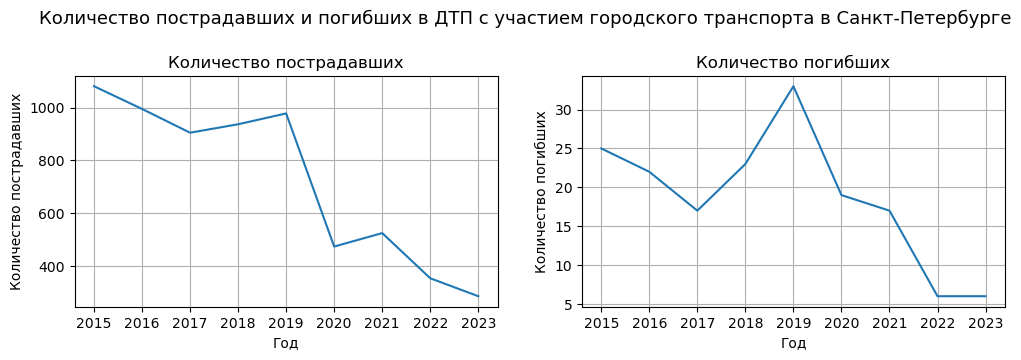

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3))
fig.suptitle('Количество пострадавших и погибших в ДТП с участием городского транспорта в Санкт-Петербурге', y=1.1, fontsize=13)

bus_spb[bus_spb['year'] != 2024].groupby('year')['injured_count'].sum().plot(ax=ax1)
ax1.set_xlabel('Год')
ax1.set_ylabel('Количество пострадавших')
ax1.set_title('Количество пострадавших')
ax1.grid()

bus_spb[bus_spb['year'] != 2024].groupby('year')['dead_count'].sum().plot(ax=ax2)
ax2.set_xlabel('Год')
ax2.set_ylabel('Количество погибших')
ax2.set_title('Количество погибших')
ax2.grid()
plt.show()

**Вывод:** Количество пострадавших и погибших в ДТП с участием городского транспорта в 2022 и 2023г. значительно снизилось. Количество ДТП с пострадавшими снизилось на 37% в 2022 и на 4,5% в 2023г., а с погибшими на 65% в 2022г. и не изменилось в 2023г. Можно предположить, что положительное влияние на ситуаию оказала транспортная реформа в СПБ, в рамках которой маршрутные такси были заменены современными автобусами.

### 5.3. Пол водителя

Проверим предположение, что женщины водители более осторожны на дорогах и менее опасны, чем водители мужчины.

In [32]:
#выберем только водителей
gender = data_participants[data_participants['role'] == "Водитель"].reset_index(drop=True)

In [10]:
#посмотрим на распределение водителей мужчин и женщин
gender.groupby('gender')['id'].count()

gender
Женский     289482
Мужской    1237679
Name: id, dtype: int64

In [33]:
#оставим только нужные столбцы
gender=gender[['id', 'gender']]

In [34]:
#избавимся от дубликатов
gender = gender.drop_duplicates().reset_index(drop=True)

In [35]:
#найдем аварии с участием и мужчин, и женщин водителей
gender.groupby('id').agg({'gender': 'nunique'}).query('gender > 1').count()

gender    171182
dtype: int64

In [36]:
#удалим такие случаи и оставаим только аварии с участием либо водителей женщин, либо водителей мужчин
two_gen = gender.groupby('id').agg({'gender': 'nunique'}).query('gender > 1').reset_index()['id'].tolist()

In [37]:
gender = gender.query('id not in @two_gen')

In [38]:
#добавим данные о количестве погибших
gender = gender.merge(data[['id', 'dead_count']], on='id')

In [39]:
#посчитаем среднее количество погибших в ДТП с водителями женщинами и водителями мужчинами
gender.pivot_table(index='gender', values='dead_count', aggfunc=['count', 'sum', 'mean'])

,count,sum,mean
,dead_count,dead_count,dead_count
gender,,,
Женский,118300,6462.0,0.054624
Мужской,1066497,137993.0,0.129389


In [29]:
#создадим функцию для категоризации поля gender
def gen(g):
    if g == "Женский":
        return 1
    return 0

In [40]:
gender['gender'] = gender['gender'].apply(gen)

In [42]:
#посмотрим есть ли связть между полом водителя и количеством погибших
gender[['gender', 'dead_count']].corr(method= 'spearman')

,gender,dead_count
gender,1.000000,-0.055179
dead_count,-0.055179,1.000000


In [43]:
#посчтиаем долю ДТП с погибшими
gen_f = gender[gender['gender'] == 1]
gen_m = gender[gender['gender'] == 0]
f_dead = gen_f[gen_f['dead_count'] != 0]
m_dead = gen_m[gen_m['dead_count'] != 0]

print('Доля ДТП с погибшими с участием водителей женщин:',round(len(f_dead)/len(gen_f),2))
print('Доля ДТП с погибшими с участием водителей мужчин:', round(len(m_dead)/len(gen_m),2))

Доля ДТП с погибшими с участием водителей женщин: 0.05
Доля ДТП с погибшими с участием водителей мужчин: 0.11


Доля ДТП с погибшими среди водителей мужчин в 2 раза выше - 11% у водителей мужчин и 5% у водителей женщин. При этом связь между гендерным признаком и количеством погибших очень слабая. Применим проверку z-критерием, чтобы узнать есть ли статистически значимая разница в долях ДТП с погибшими у водителей женщин и водителей мужчин.

Формулируем гипотезы: 
- Нулевая гипотеза: доля ДТП с погибшими с участием водителей женщин не превышает долю ДТП с погибшими с участием водителей мужчин
- Альтернативная гипотеза: доля ДТП с погибшими с участием водителей женщин ниже доли ДТП с погибшими с участием водителей мужчин, различия статистически значимы

In [68]:
alpha = .05 

dead = np.array([len(f_dead), len(m_dead)])
all_part = np.array([len(gen_f),len(gen_m)])

In [70]:
def z_test(successes, trials, alpha):

  
    alpha = alpha
    successes = successes
    trials = trials

    # пропорция успехов в первой группе:
    p1 = successes[0] / trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1] / trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) *
                                    (1 / trials[0] + 1 / trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) # гипотеза односторонняя поэтому без 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print('Не получилось отвергнуть нулевую гипотезу')

In [71]:
z_test(dead, all_part, alpha)

p-значение:  0.0
Отвергаем нулевую гипотезу


**Вывод:** Статистически значимая разница между долями ДТП с погибшими у водителей женщин и водителей мужчин есть. Женщины водители менее опасны на дорогах, чем мужчины водители, однако на количество погибших влияют и другие факторы.

## 6. Выводы

По итогам работы были сделаны следующие заключения:

- С 2015г наблюдается нисходящий тренд в количестве ДТП. Особенно значительный спад наблюдается в 2020г - 11.5%. Возможно это связано с пандемией и уменьшением трафика на улицах. В 2023г произошел рост количества ДТП - на 3,75%, в том числе с погибшими (+0,3%) и пострадавшими (+4,1%). Возможно это связано с удорожанием обслуживания и ремонта ТС, которое произошло вследствие санкций. Среди приросшего числа ДТП в 2023г наибольший рост у аварий легкой степени тяжести. Мы также видим рост среди аварий тяжелой степени тяжести, тогда как число аварий с погибшими осталось почти на прежнем уровне. В 2023г. самый значительный рост наблюдается в категориях "Столкновение" и "Не справился с управлением", что подкрепляет гипотезу о том, что рост ДТП связан с увеличением количества неисправных ТС. Однако, фактически количество ДТП по причине неисправности ТС в 2022 и 2023г. уменьшилось. Необходимо иметь в виду, что данные не позволяют нам достоверно оценить изменения в количестве неисправных авто на дорогах и их влияние на количество ДТП.
- Самое высокое количество ДТП наблюдаются с июля по сентябрь. Возможно это связано с повышением трафика на улицах в летние месяца.
- Дни с наибольшим количеством аварий - пятница и суббота. Возможно, это связано с повышением трафика в эти дни или с повышением количества водителей в нетрезвом виде.
- Наибольшее количество аварий наблюдается с 17 до 19 часов. Вероятно это опять же связано с повышением трафика на улицах.
- Больше половины аварий - это аварии лекгой степени тяжести. Треть аварий приходится на аварии тяжелой степени тяжести и почти каждая 10ая авария заканчивается смертельным исходом.
- Почти половина аварий происходит по причине столкновения автомобилей. На втором месте - наезд на человека, такие аварии составляют почти треть от числа ДТП. 12% аварий приходятся на категорию "Не справился с управлением" (съезд с дороги и опрокидывание).
- Наиболшие доли погибших в категориях "Не справился с управлением", "Наезд на препятствие" и "Наезд на человека".
- Наибольшая доля погибших в ДТП, которые происходят в туман, ураганный ветер и метель.
- Наибольшие доли ДТП с погибшими и с тяжелыми последствиями приходятся на ДТП, которые случились в темное время суток и без освещения. ДТП, которые произошли в темное время суток, но с освещением, имееют гораздо более низкий процент погибших. Необходимо направить больше усилий на обеспечение хорошего освещения на дорогах.
- В рамках дорожных условий, наибольший процент погибших снова наблюдается в ДТП, которые случились в условиях отсутствия или неисправного освещения. Также в топе по проценту погибших такие категории, как неудовлетворительное состояние обочин, отсутствие тротуаров и дорожных ограждений. Также необходимо отметить, что ДТП в условиях отсутствия или плохой различимости вертикальной разметки в 50% случаев имеют тяжелые последствия.
- Среди регионов с самой большой долей ДТП с погибшими и тяжелыми последствиями находятся Чеченская Республика, Республика Ингушетия, Кабардино-Балкарская Республика и Республика Дагестан. Регионы с наименьшей долей ДТП с погибшими и тяжелыми последствиями - Тюменская область, Севастополь, Амурская и Кировские области и Москва. Наименьшая доля ДТП с погибшими в Санкт-Петербурге.
- Топ 7 нарушений с самой высокой долей погибших и раненных относятся к нарушению со стороны пешеходов. В Топ 15 нарушений также попали управление велосипедом без светоотражающих элементов, нарушение правил переезда ж/д переездов, езда без ремня безопасности, езда в состоянии алкогольного опьянения.
- Наибольшая доля погибших и ранныеных приходится на пешеходов и велосипедистов. Более строгие правила ДД для этих категорий участников и более строгий их контроль, а также создание безопасных зон (велосипедные дорожки, ограждения) могут помочь снизить количество пострадавших. Интересно, что среди пассажиров пострадавших около 85% , тогда как среди водителей пострадали только 40%. 
- Более 50% нарушений со стороны пассажира - езда без ремня безопасности. Более строгие штрафы за езду без ремня для пассажиров могут помочь снизить количество пострадавших.
- Погибших среди водителей мужчин в 2 раза больше, чем среди водителей женщин. При этом в целом мужчины чаще выходят из ДТП без последствий. Можно предположить, что женщины более осторожны на дорогах и реже попадают в тяжелые ДТП.
- Наибольший % погибших среди водителей со стажем более 40 лет. Наименьший % погибших - среди водителей новичков, со стажем менее 3 лет. При этом % раненых среди новичков самый большой. Можно предположить, что они осторожны на дорогах и реже попадают в тяжелые аварии, но в силу малого опыта чаще попадают в аварии в целом.

В рамках исследования были также проверены следующие предположеня:

1. Российские марки ТС представляют больше опасности на дорогах, чем иностранные марки:

Доля погибших в ДТП с участием российских марок и иностранных марок различается слабо - 9% и 12%. Однако, статистически значимая разница между долями ДТП есть. Соответственно можно сказать, что ТС российских марок представляют большую опасность на дорогах, чем ТС иностранных марок, однако на количество погибших влияют и другие факторы.

2. Количество аварий в Санкт-Петербурге снизилось после транспортной реформы:

Было оценено влияние транспортной реформы в СПБ, реализованной в 2022г, в рамках которой были изменены маршруты автобусов, произведена замена автобусов на более современные и были убраны с дорог маршрутки. Количество ДТП в 2022г. в СПБ снизилось на 15%, в том числе ДТП с погибшими снизилось на 29% и с пострадавшими на 15%. В отличие от статистики по всем региоам в целом, где в 2023г. наблюдался рост ДТП, в Санкт-Петербурге мы наблюдаем снижение в количестве ДТП на 2%, в том числе с погибшими на 7,3% и пострадавшими на 1,8%. Количество ДТП с участием городского транспорта с пострадавшими и погибшими значительно снизилось в 2022 и 2023г. Количество ДТП с пострадавшими снизилось на 37% в 2022 и на 4,5% в 2023г., а с погибшими на 65% в 2022г. и не изменилось в 2023г. Можно предположить, что положительное влияние на ситуацию оказала транспортная реформа в СПБ, в рамках которой маршрутные такси были заменены современными автобусами.

3. Женщины водители более осторожны на дорогах и менее опасны, чем водители мужчины:

Доля ДТП с погибшими среди водителей мужчин в 2 раза выше - 11% у водителей мужчин и 5% у водителей женщин. Статистически значимая разница между долями ДТП с погибшими у водителей женщин и водителей мужчин есть. Женщины водители менее опасны на дорогах, чем мужчины водители, однако на количество погибших влияют и другие факторы.